## 1. Import Libraries

Import necessary libraries. NumPy is used for numerical operations, Matplotlib for plotting, and random for generating random numbers.

In [85]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## 2. Constants

Define constants used in the simulation. These include the probabilities of fire spread for different vegetation types, the angle of the wind, the ratio of water cells, and the color map for visualization.

In [86]:
VEGETATION_FIRE_SPREAD_PROBABILITIES = {
    'NormalForest': 1.0,
    'DryGrass': 1.5,
    'DenseTrees': 0.5,
    'Water': 0.0
}
WIND_ANGLE = 30
WATER_RATIO = 0.175

color_map = {
    'NormalForest': 'green',
    'DryGrass': 'yellow',
    'DenseTrees': 'darkgreen',
    'Water': 'blue',
    'Burning': 'red',
    'Burned': 'black'
}

## 3. Initialize Grid

Define the function to initialize the grid with a specific size. The grid is initialized with normal forest cells, and specific cells are set to burning, dry grass, and dense trees. Additionally, a certain ratio of water cells is randomly distributed across the grid.

In [87]:
def initialize_grid(m, n):
    grid = [['NormalForest' for _ in range(n)] for _ in range(m)]
    grid[m//2][n//2] = 'Burning'
    grid[m//4][n//4] = 'DryGrass'
    grid[3*m//4][n//4] = 'DenseTrees'
    
    num_water_cells = int(m * n * WATER_RATIO)
    for _ in range(num_water_cells):
        i, j = np.random.randint(m), np.random.randint(n)
        grid[i][j] = 'Water'
    
    return grid

## 4. Neighbours

Define the function to find the neighboring cells of a given cell in the grid. This function is used to determine which cells are adjacent to a burning cell for the fire propagation.

In [88]:
def neighbours(grid, i, j):
    m, n = len(grid), len(grid[0])
    return [(i+a, j+b) for a, b in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)] if 0 <= i+a < m and 0 <= j+b < n]

## 5. Calculate Angle

Defines the function that calculate the angle between two cells inside the grid to then be used to determine the influence of the wind direction on the fire 

In [89]:
def calculate_angle(cell, neighbor):
    di = neighbor[0] - cell[0]
    dj = neighbor[1] - cell[1]
    angle = math.atan2(di, dj) * (180 / math.pi)
    return angle % 360

## 6. Calculate the humidity across the grid

Function that calculates the humidity from cells to cells to the nearest water source/cells, used to determine across the grid the levels of humidity

In [90]:
def humidity_cross_grid(grid):
    m, n = len(grid), len(grid[0])
    distance_grid = [[float('inf') for _ in range(n)] for _ in range(m)]
    
    for i in range(m):
        for j in range(n):
            if grid[i][j] == 'Water':
                distance_grid[i][j] = 0
    
    for i in range(m):
        for j in range(n):
            if i > 0:
                distance_grid[i][j] = min(distance_grid[i][j], distance_grid[i-1][j] + 1)
            if j > 0:
                distance_grid[i][j] = min(distance_grid[i][j], distance_grid[i][j-1] + 1)
    
    for i in range(m-1, -1, -1):
        for j in range(n-1, -1, -1):
            if i < m - 1:
                distance_grid[i][j] = min(distance_grid[i][j], distance_grid[i+1][j] + 1)
            if j < n - 1:
                distance_grid[i][j] = min(distance_grid[i][j], distance_grid[i][j+1] + 1)
                
    return distance_grid

## 7. Calculate the humidity

Defines the calculation needed for the function the humidities levels that reduces the probability for a cell to catch fire 

In [91]:
def calculate_humidity(grid):
    distance_grid = humidity_cross_grid(grid)
    max_distance = max(max(row) for row in distance_grid)
    humidity_grid = [[1 - (distance / max_distance) for distance in row] for row in distance_grid]
    return humidity_grid

## 8. Calculate the Directional Influence

Define the function that returns calculates the influence of the direction of the wind on the fire, based on the wind direction (or angle) between cells 

In [92]:
def calculate_directional_influence(w_direction, angle):
    angle_diff = abs(w_direction - angle)
    angle_diff = min(angle_diff, 360 - angle_diff)
    influence_factor = 1 - (angle_diff / 180)
    return influence_factor

## 9.Propagate with humidity

Define the function that updates the state of a single cell based on its neighbors cells, taking into account the humidity, wind and terrain elevation  

In [93]:
def propagate_with_humidity(grid, i, j, p, pstart, w_speed, w_direction, terrain, humidity):
    current_state = grid[i][j]
    if current_state == 'Burning':
        return 'Burned'
    if current_state in ['Burned', 'Water']:
        return current_state
    
    neighbors = neighbours(grid, i, j)
    for ni, nj in neighbors:
        if grid[ni][nj] == 'Burning':
            angle = calculate_angle((i, j), (ni, nj))
            directional_influence = calculate_directional_influence(w_direction, angle)
            
            elevation_diff = terrain[ni, nj] - terrain[i, j]
            terrain_influence = 1 + elevation_diff / 100
            
            vegetation_factor = VEGETATION_FIRE_SPREAD_PROBABILITIES.get(current_state, 1.0)
            humidity_factor = 1 - humidity
            
            adjusted_p = p * vegetation_factor * terrain_influence * humidity_factor * (1 + 0.1 * w_speed * directional_influence)

            adjusted_p = max(0, min(1, adjusted_p))
            
            if random.random() < adjusted_p:
                return 'Burning'
    
    if random.random() < pstart:
        return 'Burning'
    
    return current_state
    

## 10. Update Grid

Define the function to update the entire grid for one iteration of the simulation, considering all influencing factors.

In [94]:

def update_grid(grid, p, pstart, w_speed, w_direction, terrain, humidity_grid):
    m, n = len(grid), len(grid[0])
    new_grid = [[None for _ in range(n)] for _ in range(m)]
    for i in range(m):
        for j in range(n):
            new_grid[i][j] = propagate_with_humidity(grid, i, j, p, pstart, w_speed, w_direction, terrain, humidity_grid[i][j])
    return new_grid
    

## 11. Convert Grid to RGB

Define the function to convert the grid's state to an RGB array for visualization.

In [95]:

def convert_grid_to_rgb(grid):
    m, n = len(grid), len(grid[0])
    rgb_array = np.zeros((m, n, 3))
    for i in range(m):
        for j in range(n):
            rgb_array[i, j] = mcolors.to_rgb(color_map[grid[i][j]])
    return rgb_array
    

## 12. Plot Grid

Define the function to plot the grid's state using Matplotlib.

In [96]:

def plot_rgb_grid(rgb_array, title="Forest Fire Simulation"):
    fig, ax = plt.subplots()
    ax.imshow(rgb_array, aspect='auto')
    # setting the size of the image to be bigger
    fig.set_size_inches(24, 24)
    
    m, n, _ = rgb_array.shape
    ax.set_xticks(range(n))
    ax.set_yticks(range(m))
    ax.set_xticklabels(range(n))
    ax.set_yticklabels(range(m))
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    
    plt.title(title)
    plt.show()
    

## 13. Simulate Function

Define the function to orchestrate the forest fire simulation over multiple iterations.

In [97]:

def simulate(initial_grid, p, pstart, num_iterations, plot_interval, w_speed, w_direction, terrain):
    current_grid = initial_grid
    humidity_grid = calculate_humidity(initial_grid)
    for iteration in range(num_iterations):
        current_grid = update_grid(current_grid, p, pstart, w_speed, w_direction, terrain, humidity_grid)
        current_grid_rgb = convert_grid_to_rgb(current_grid)
        if iteration % plot_interval == 0 or iteration == num_iterations - 1:
            print(f"Iteration: {iteration}")
            plot_rgb_grid(current_grid_rgb)
    return current_grid
    

## 14. Main Simulation

Define the main part of the script to set up and run the simulation.

Iteration: 0


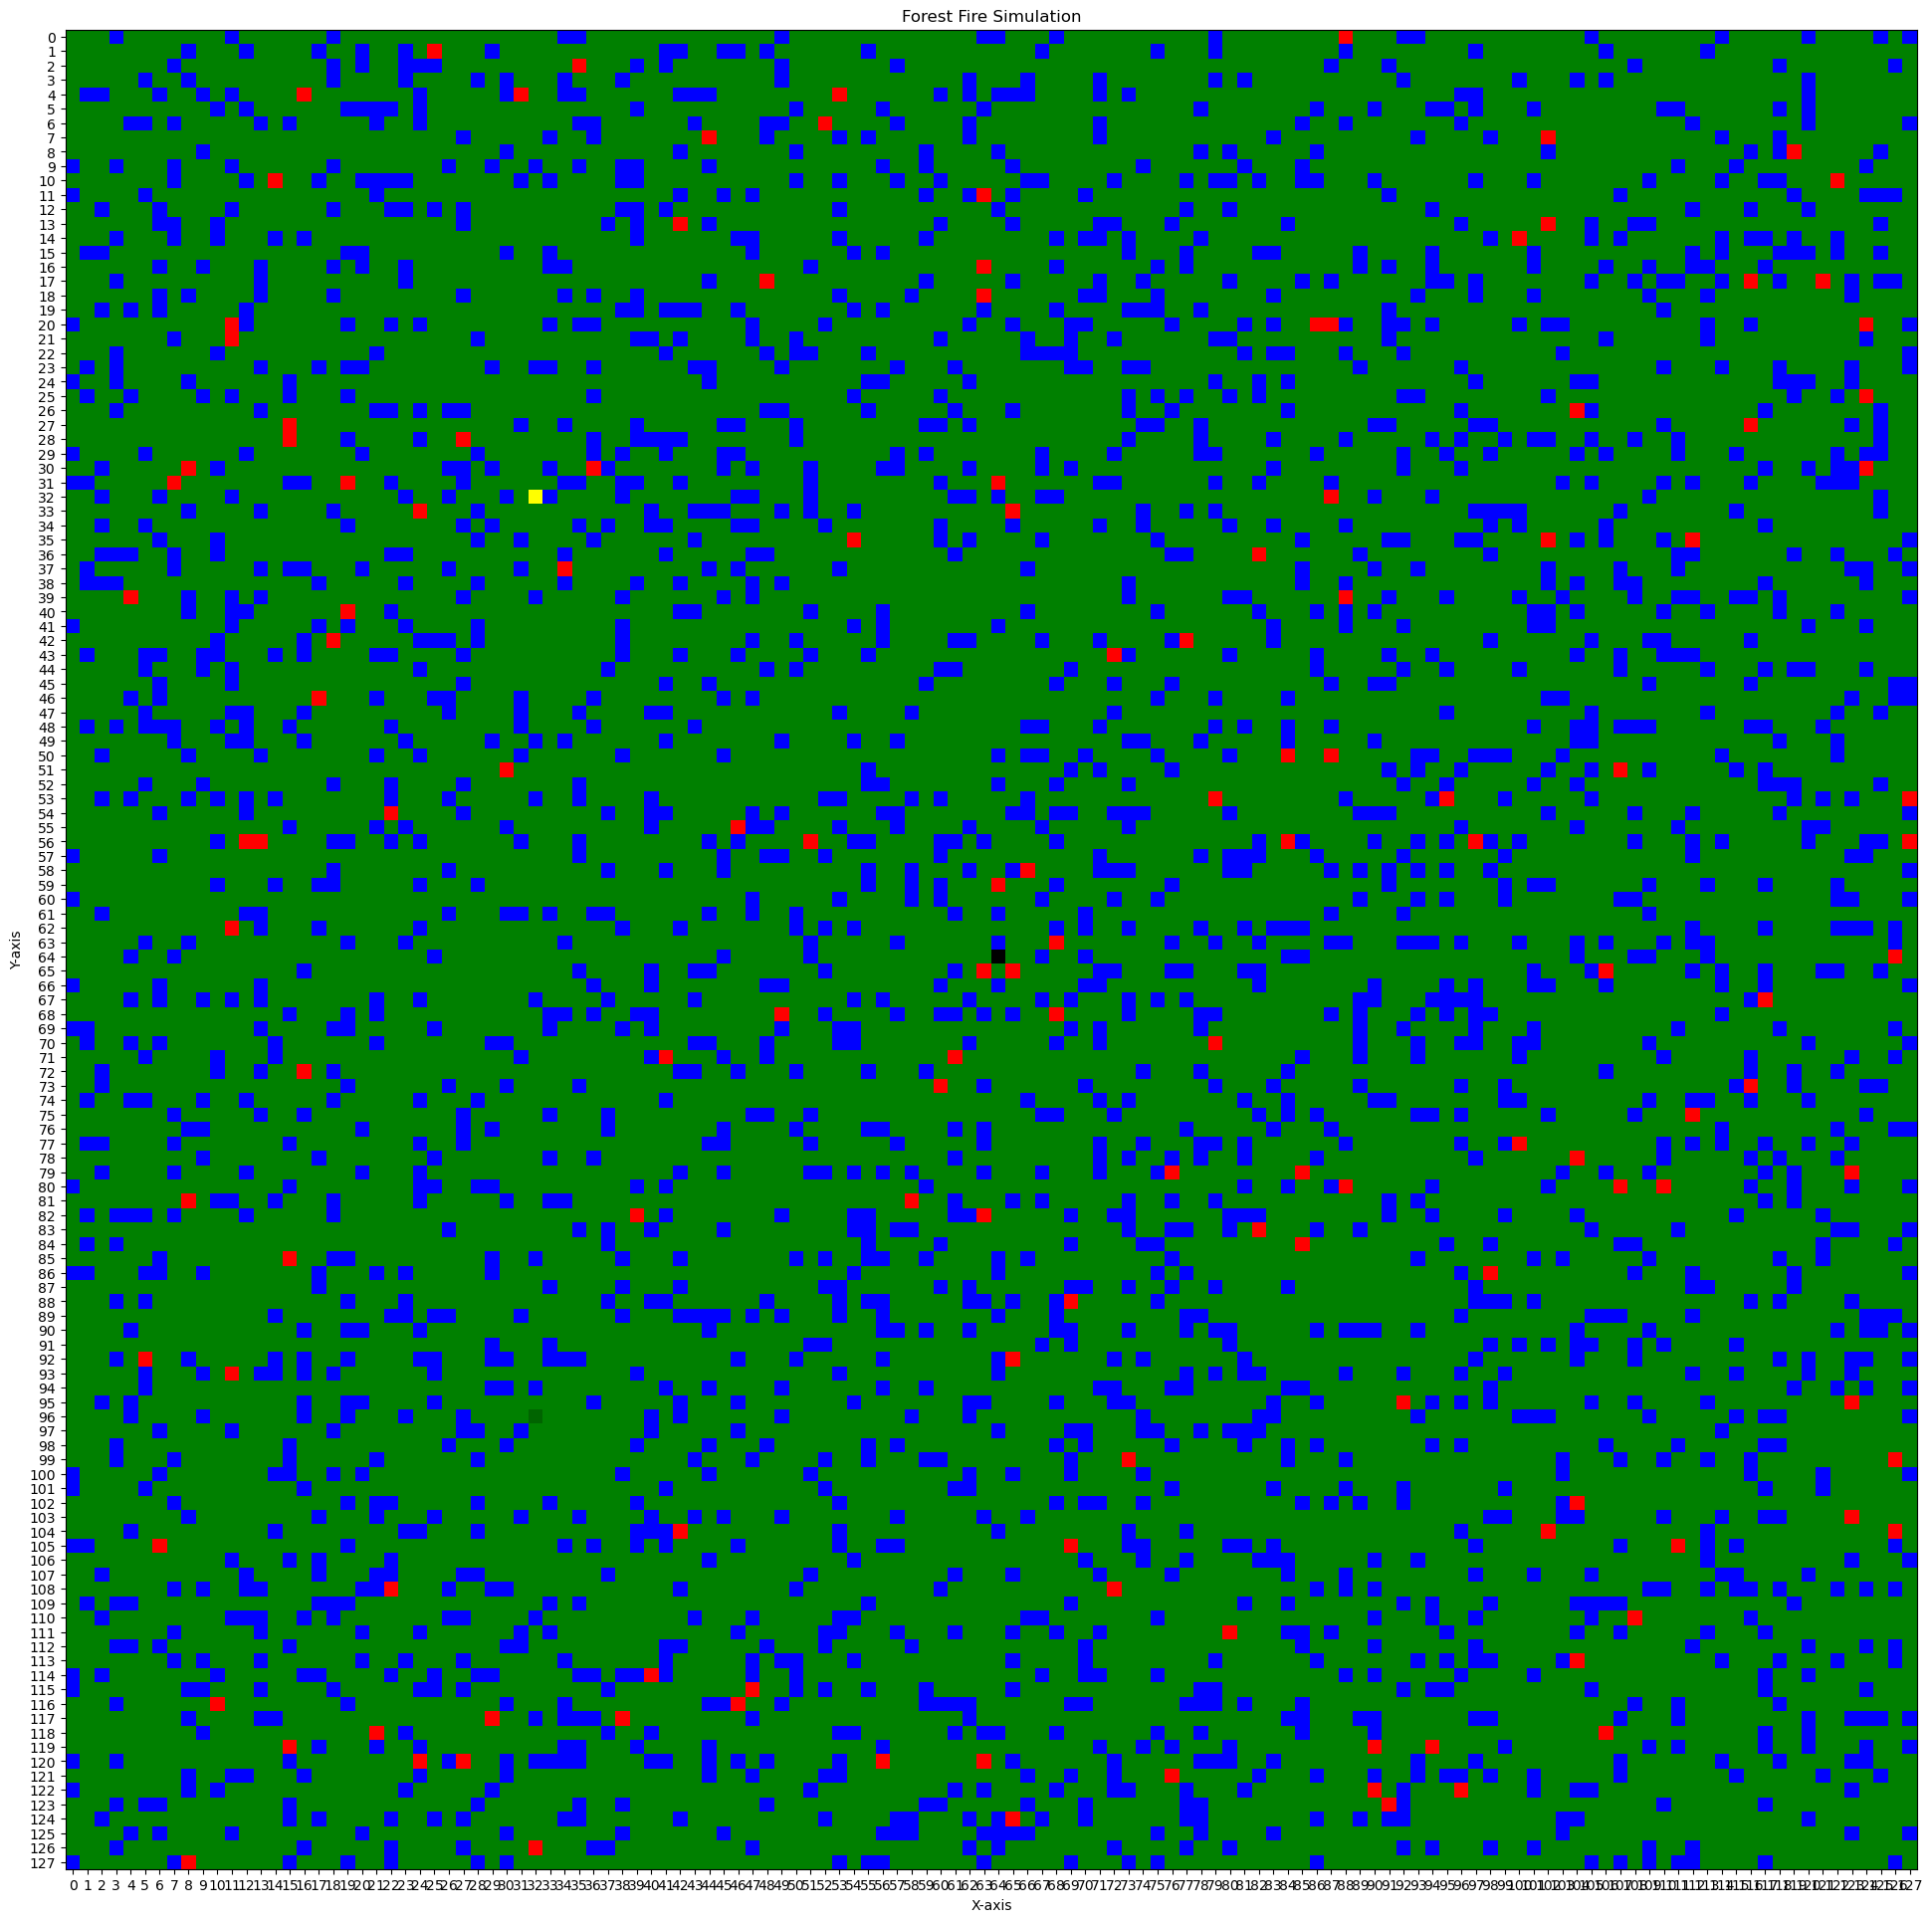

Iteration: 3


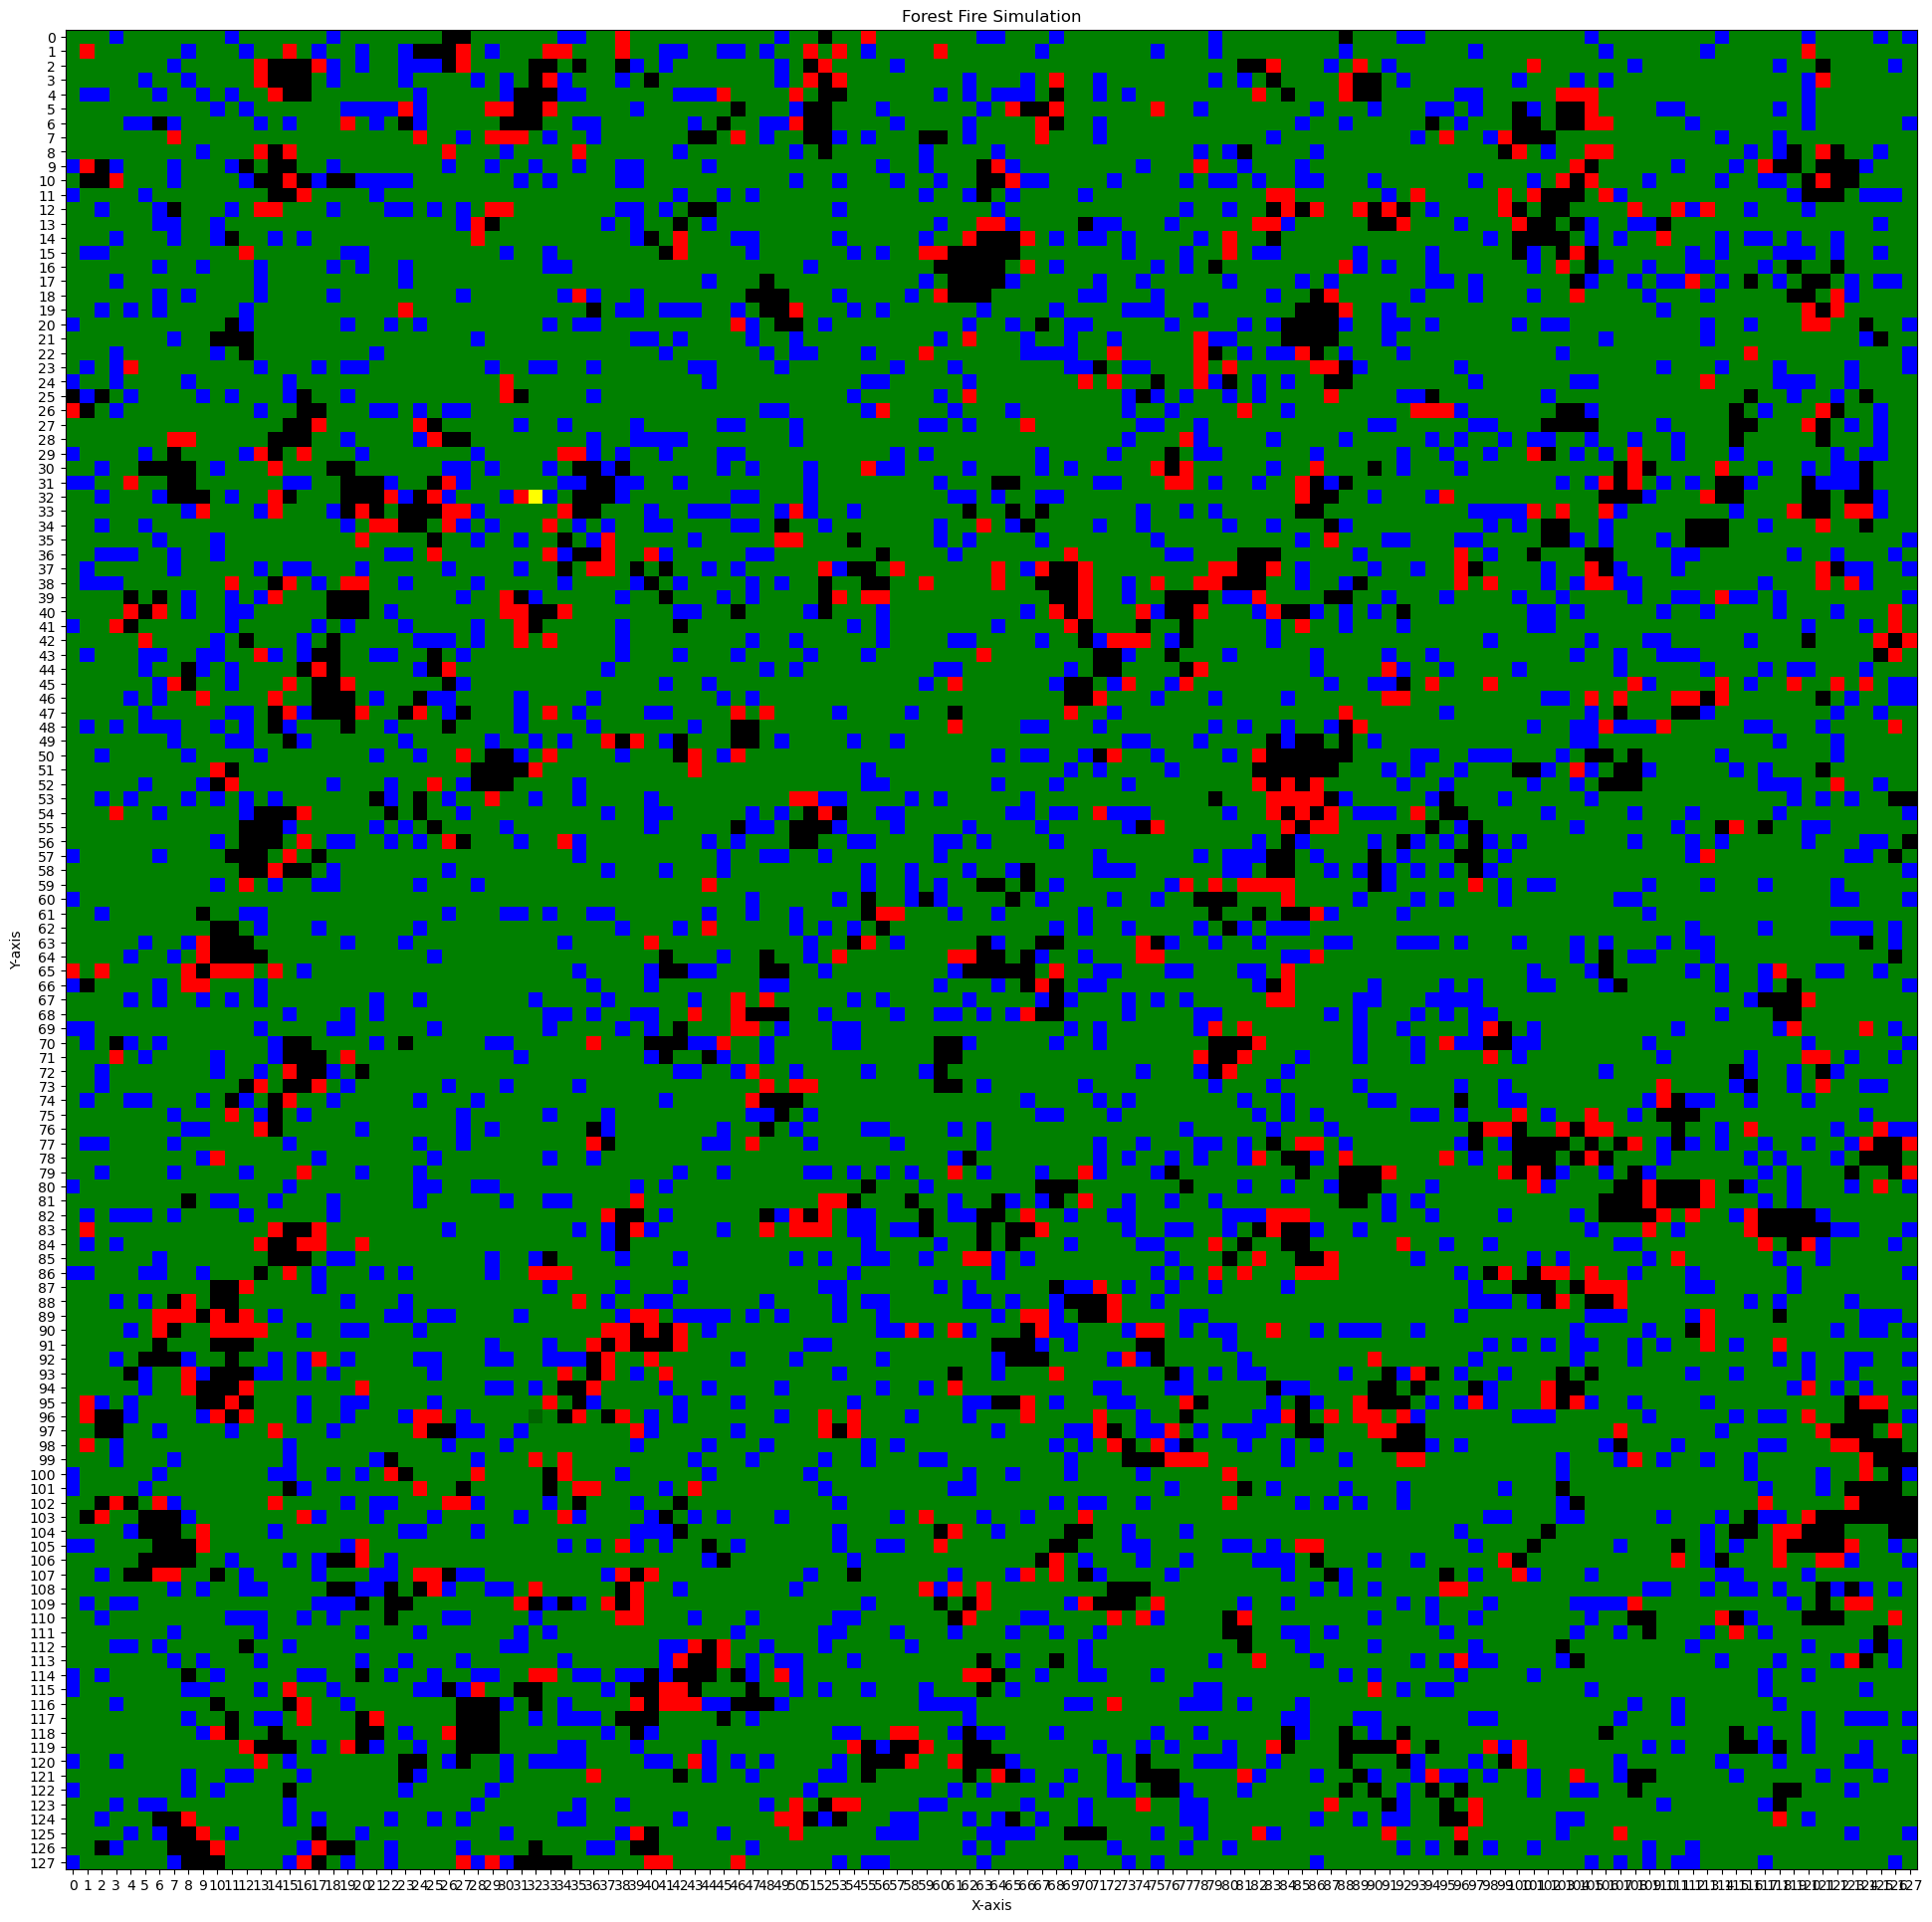

Iteration: 6


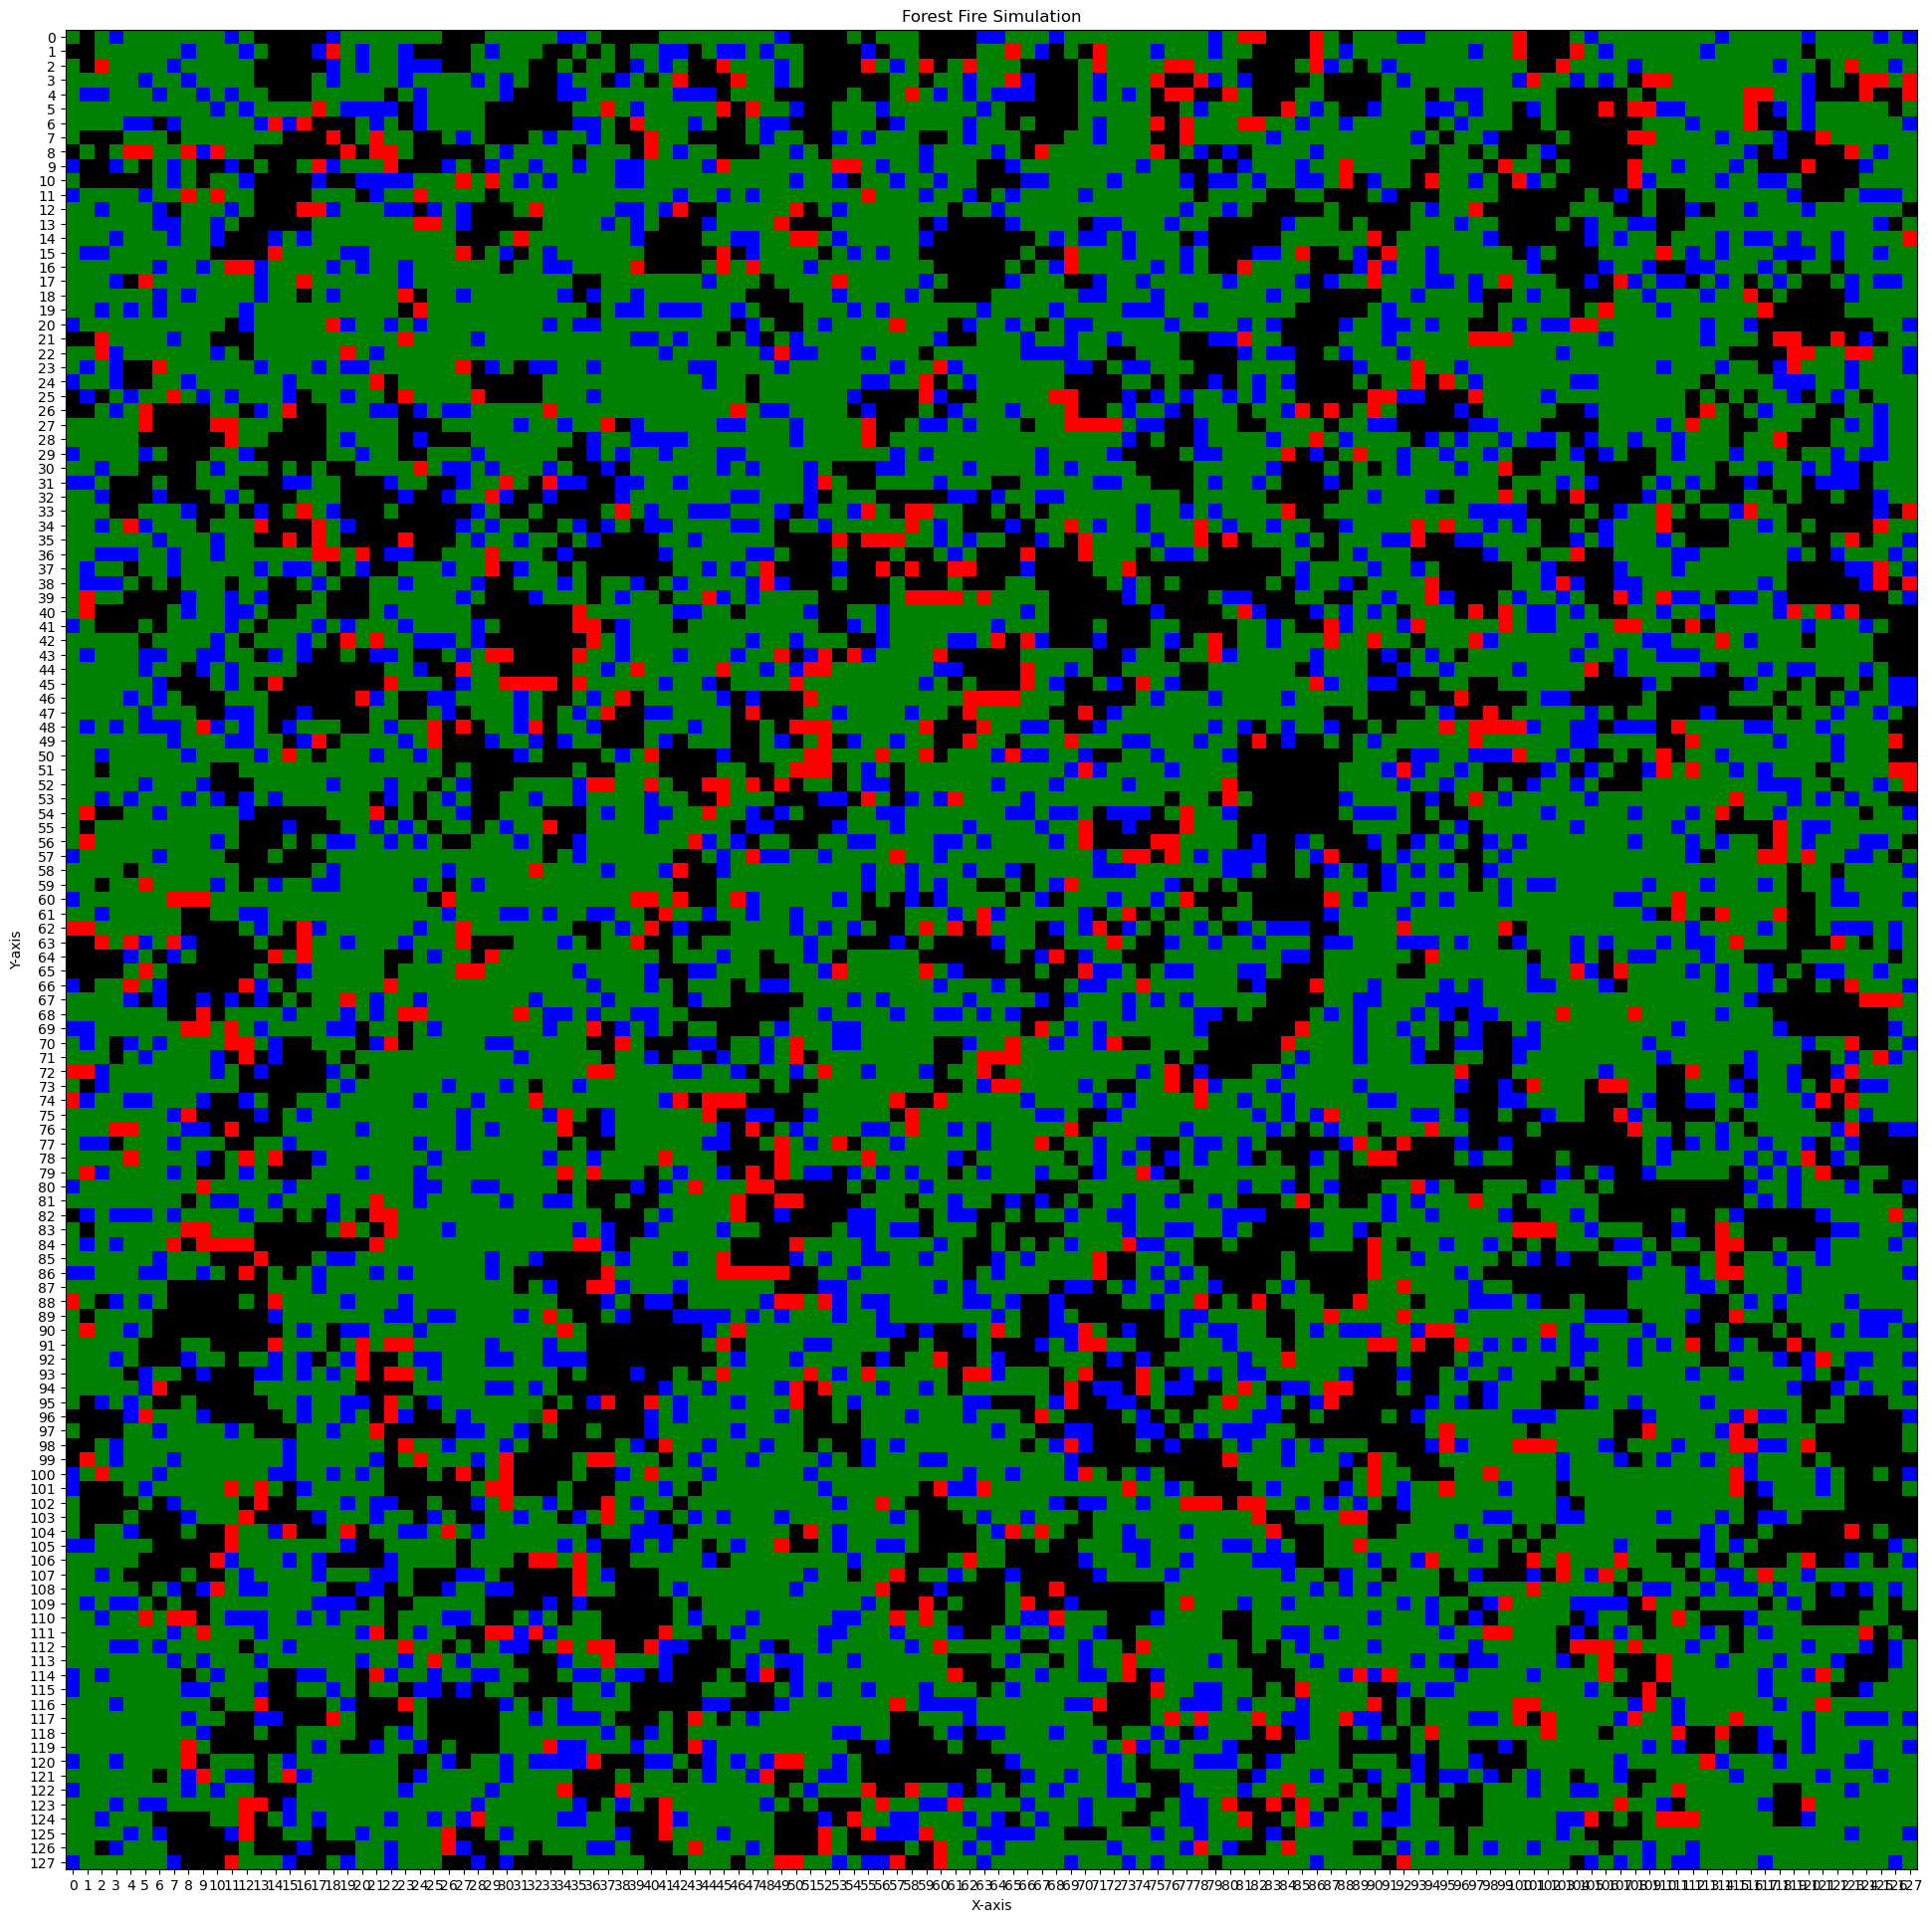

Iteration: 9


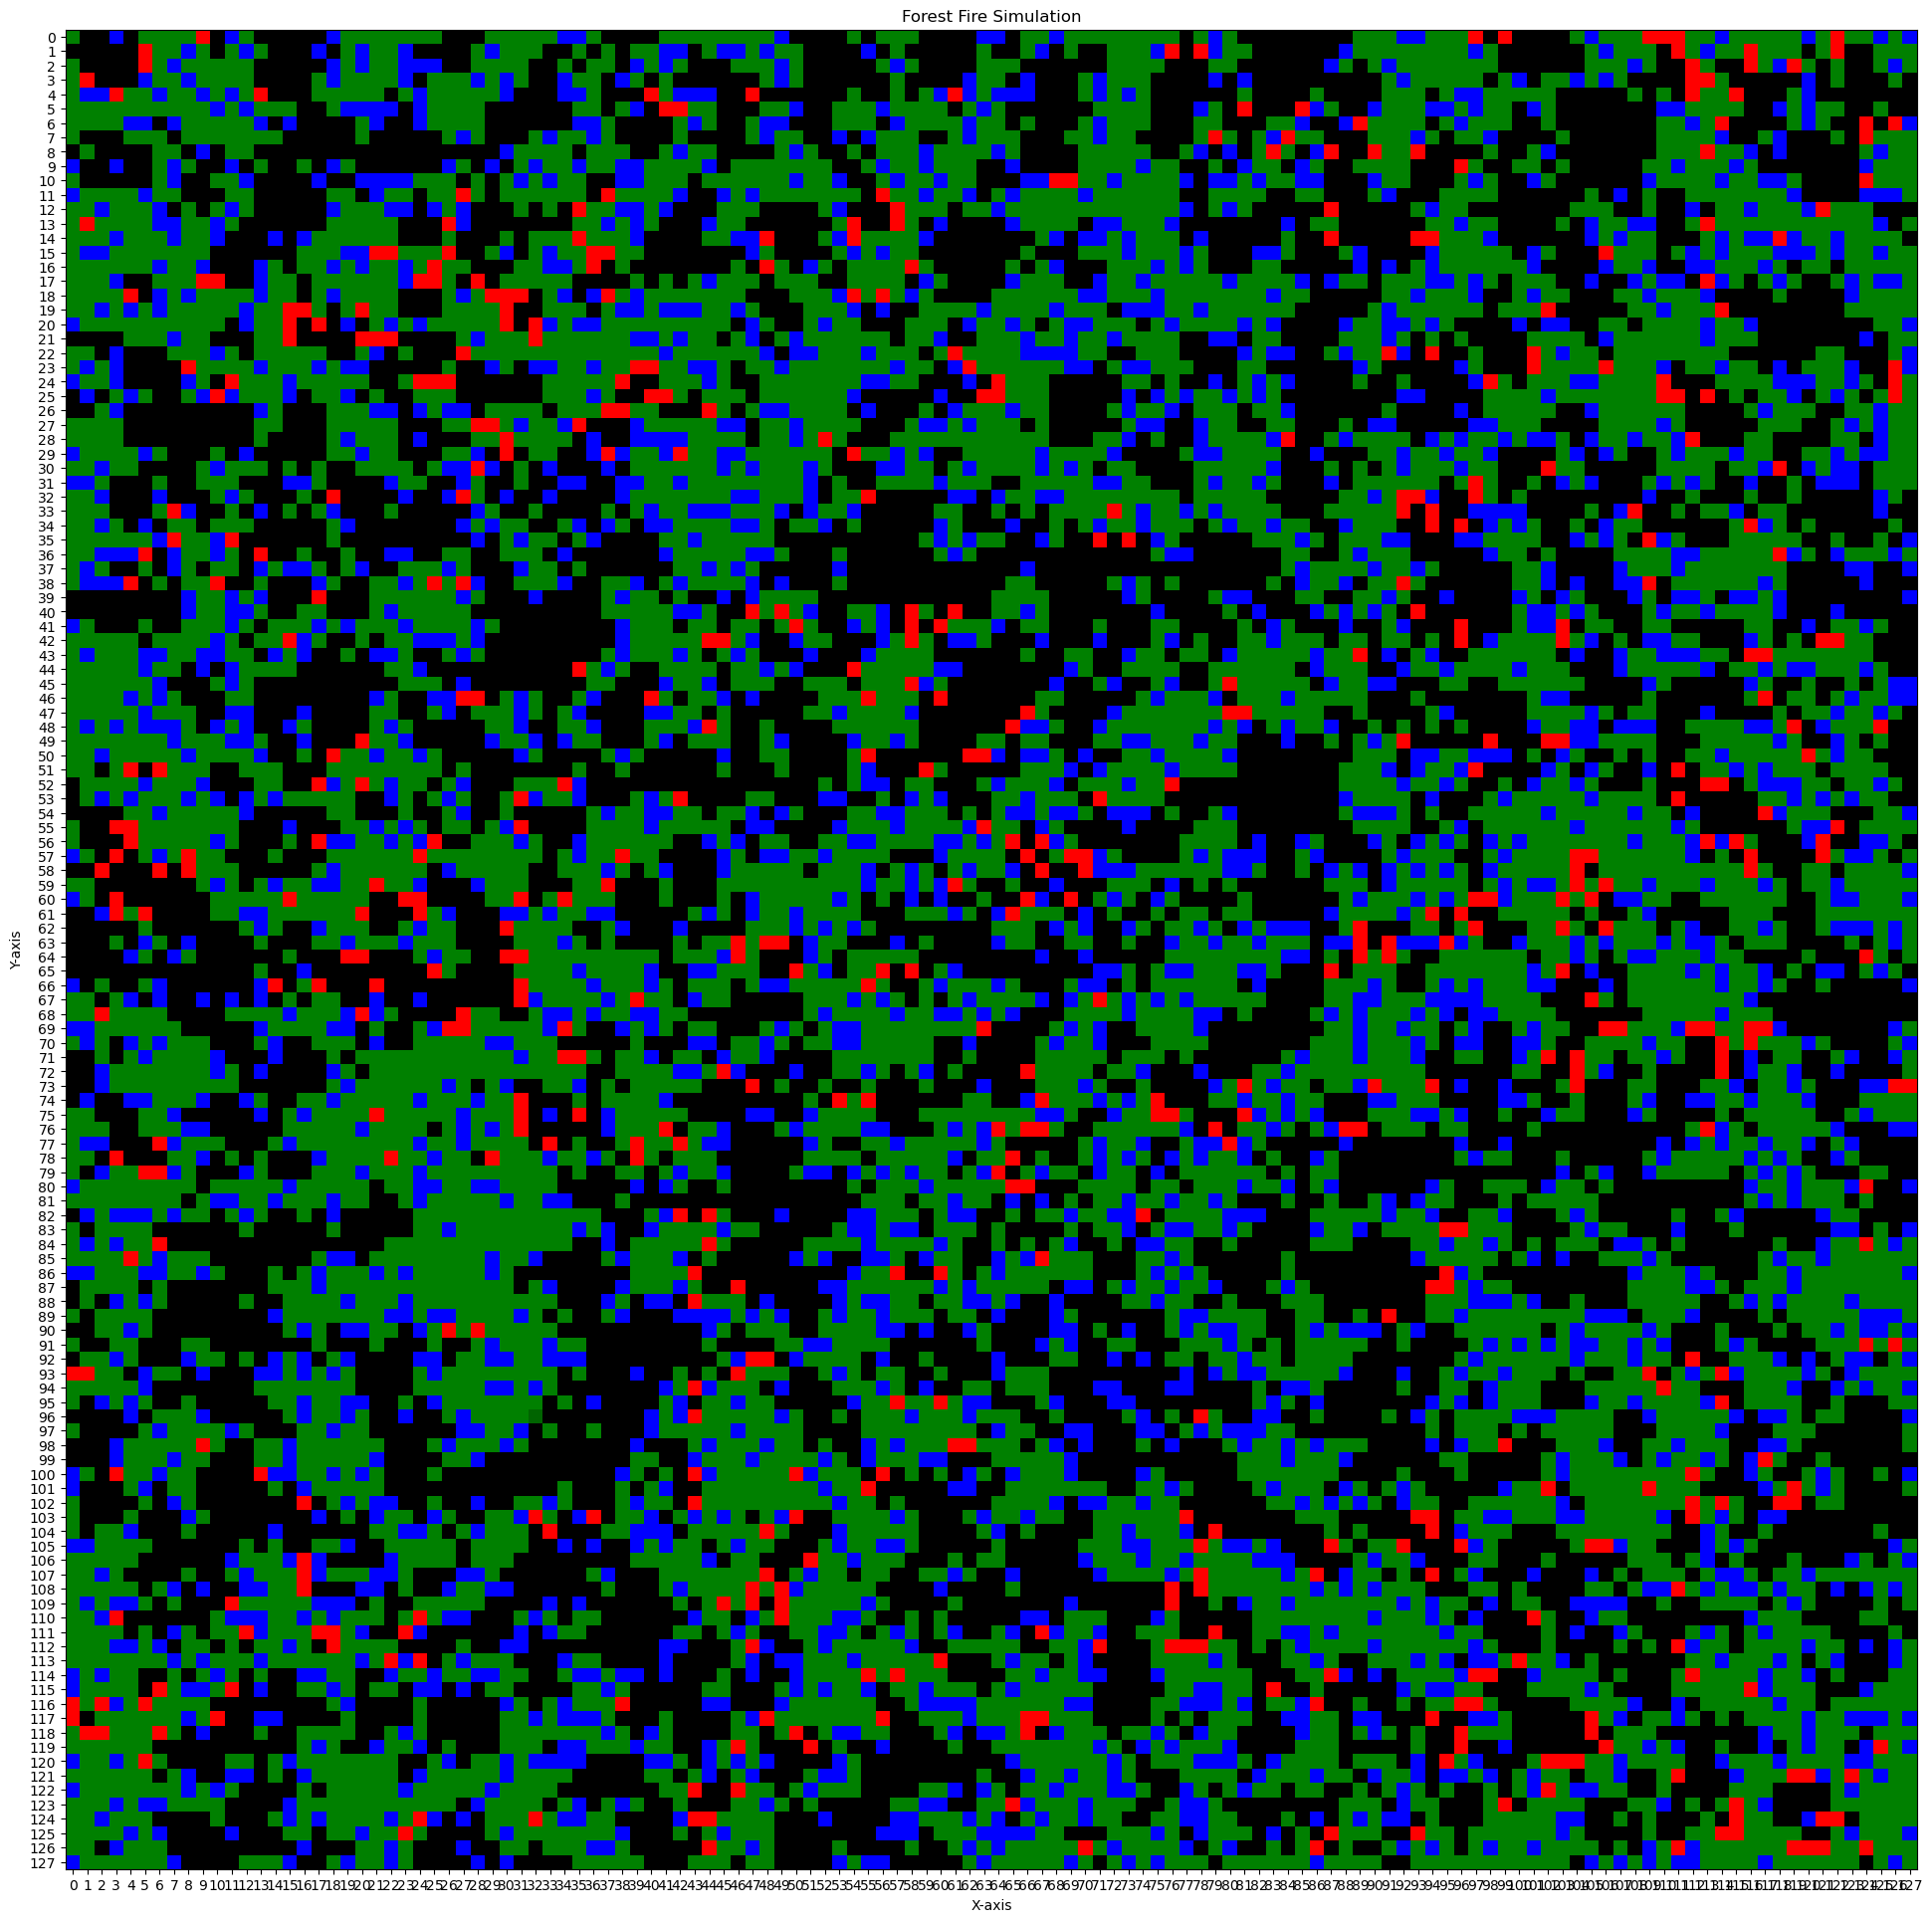

Iteration: 12


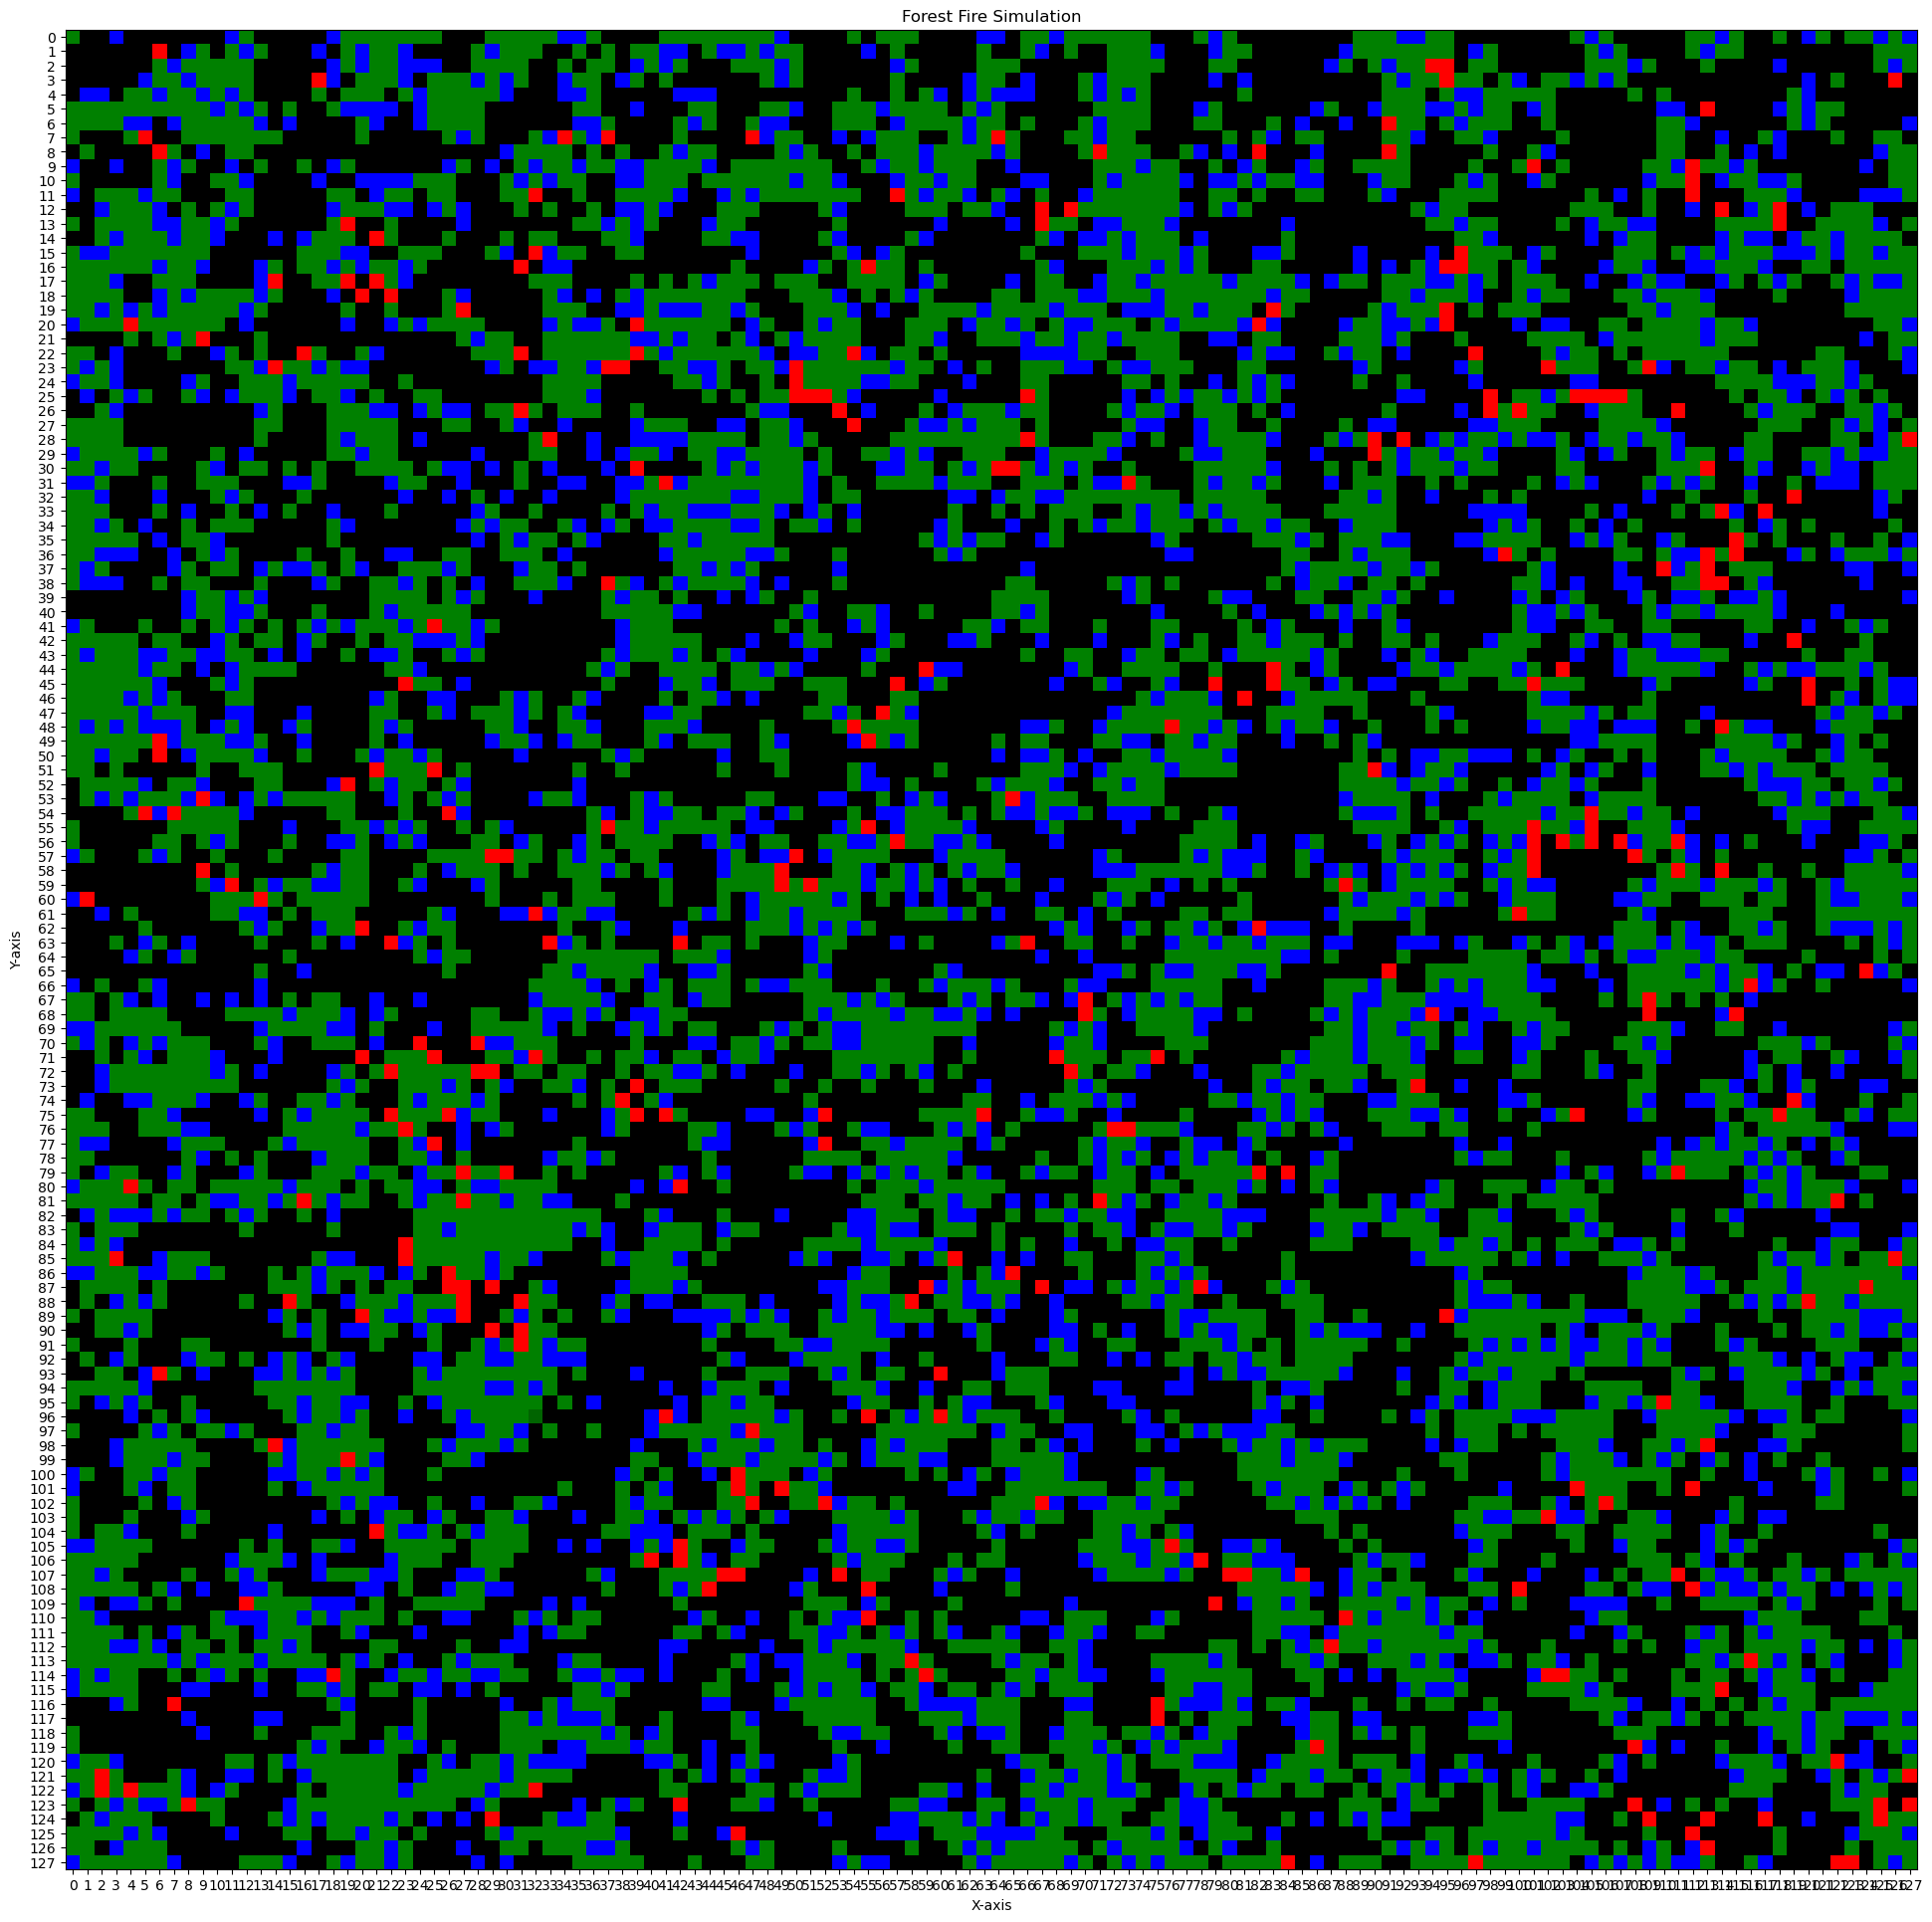

Iteration: 15


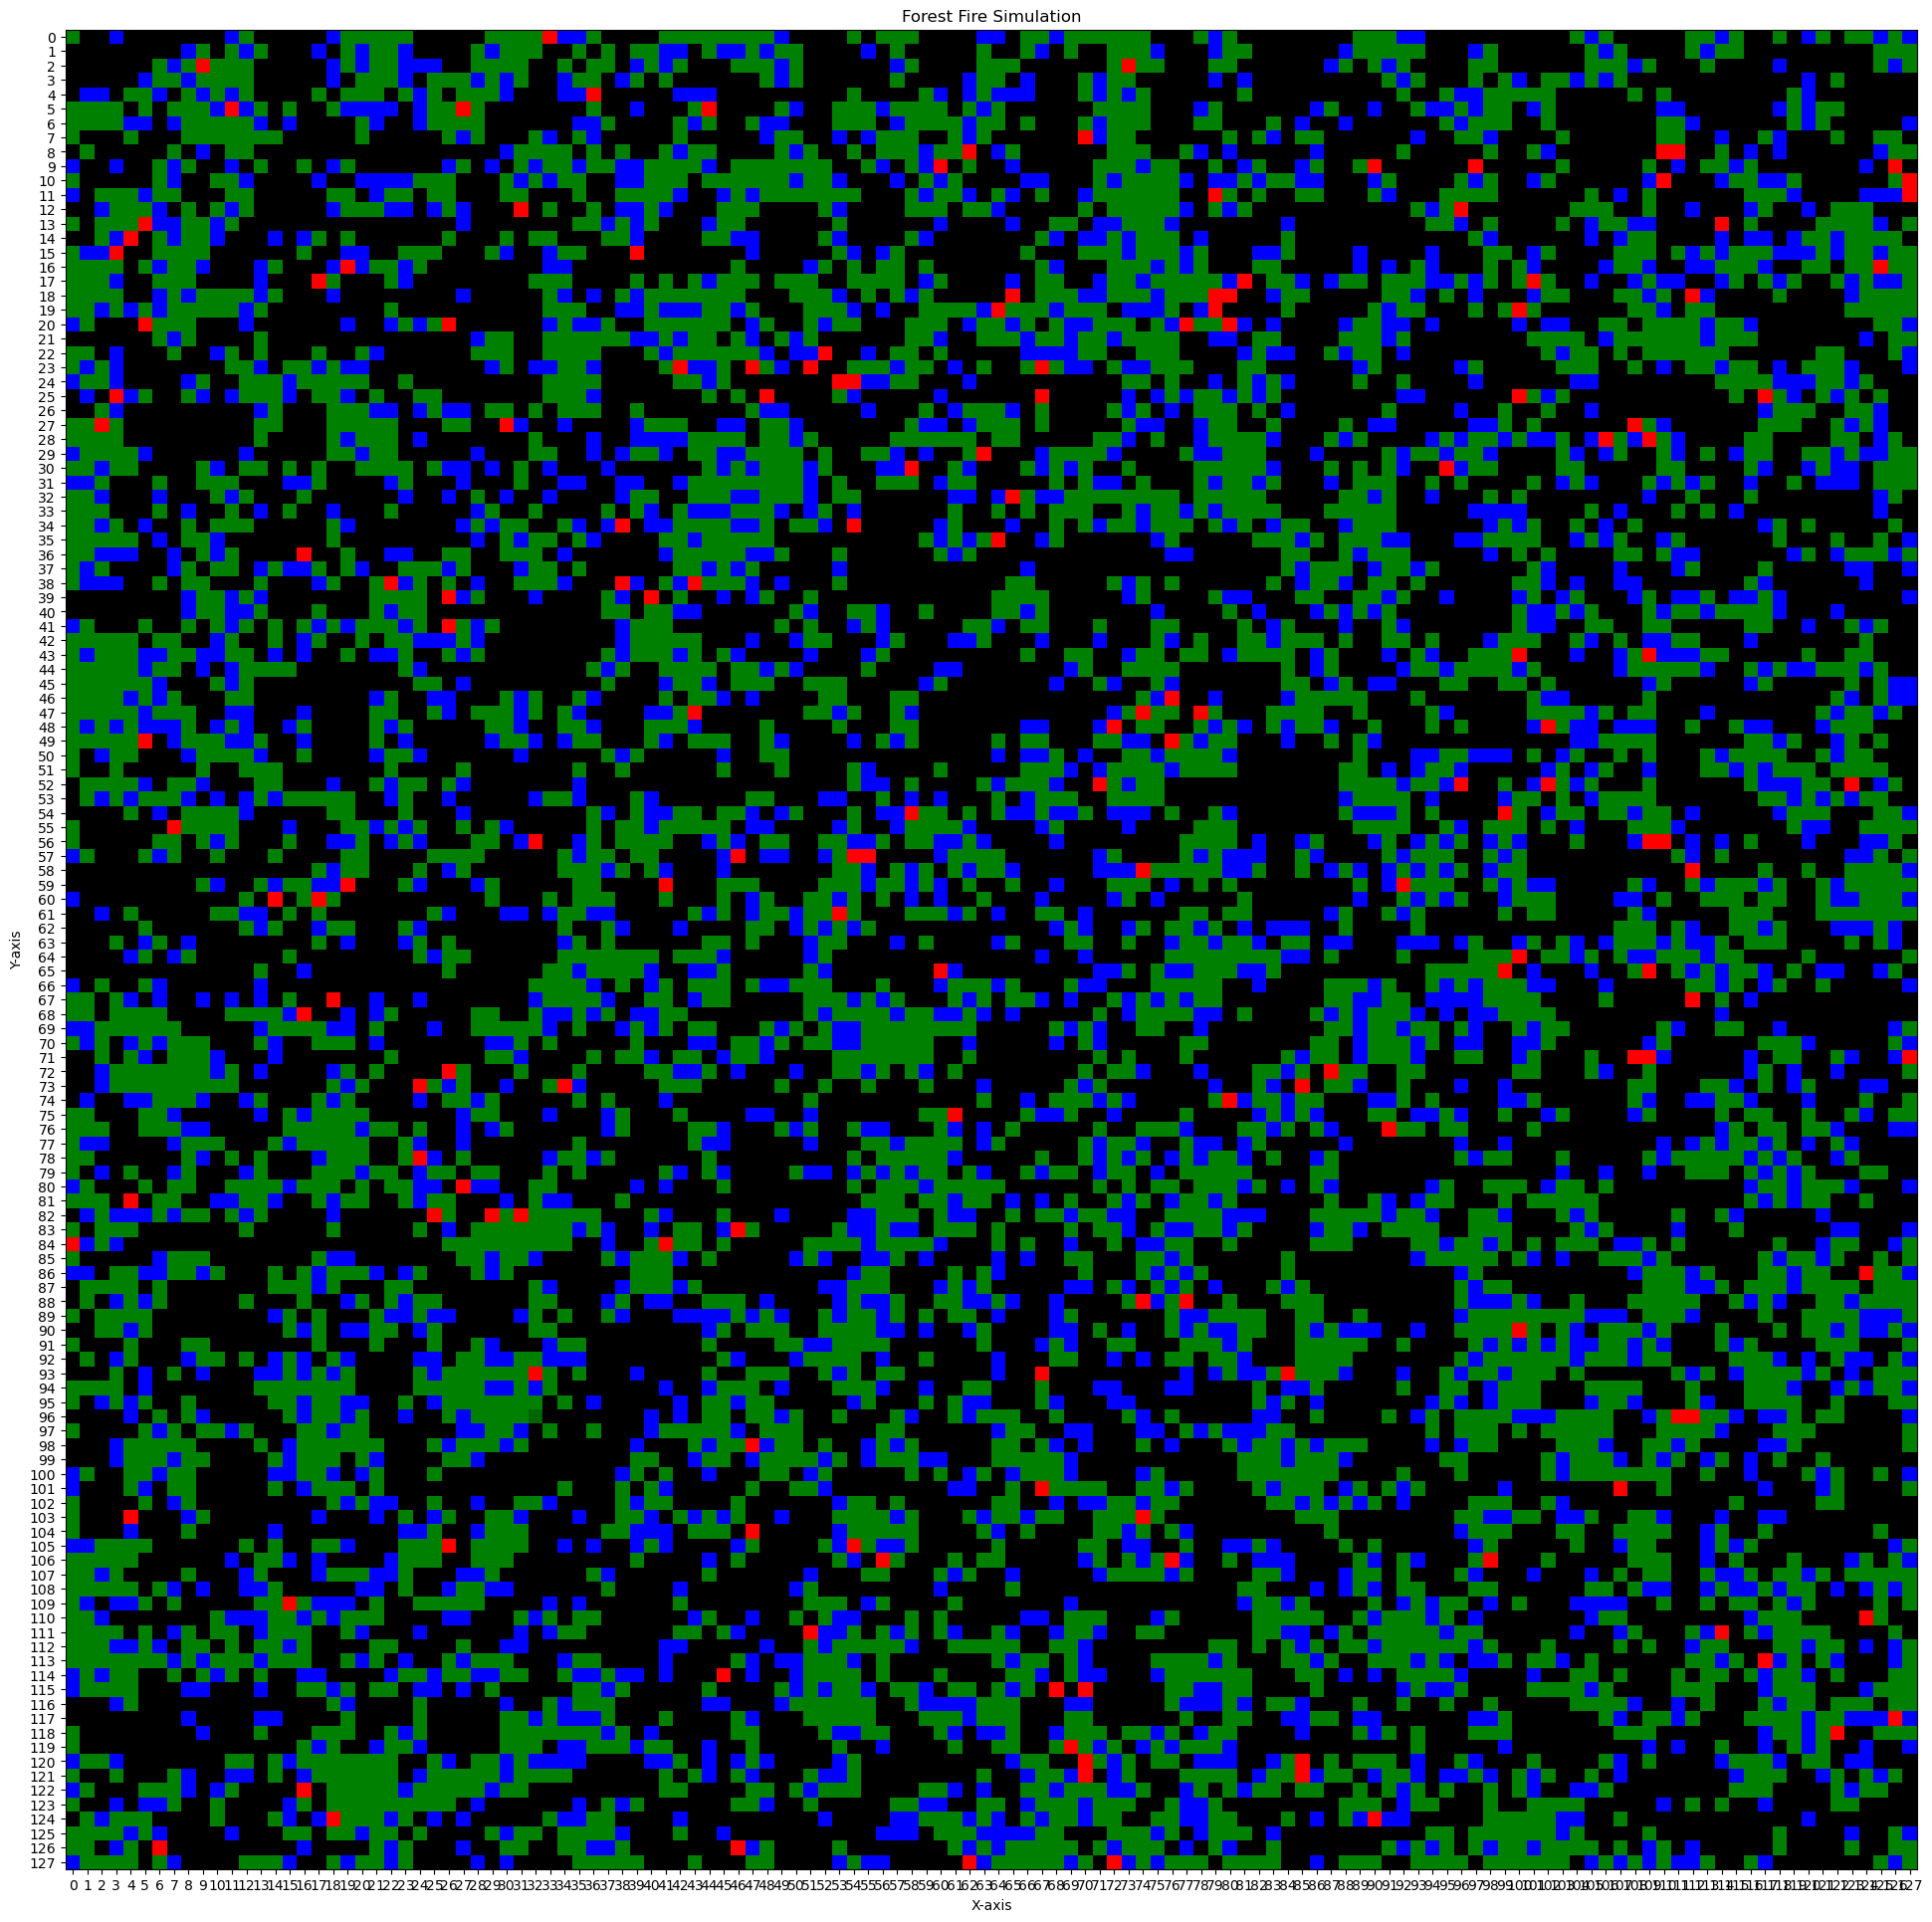

Iteration: 18


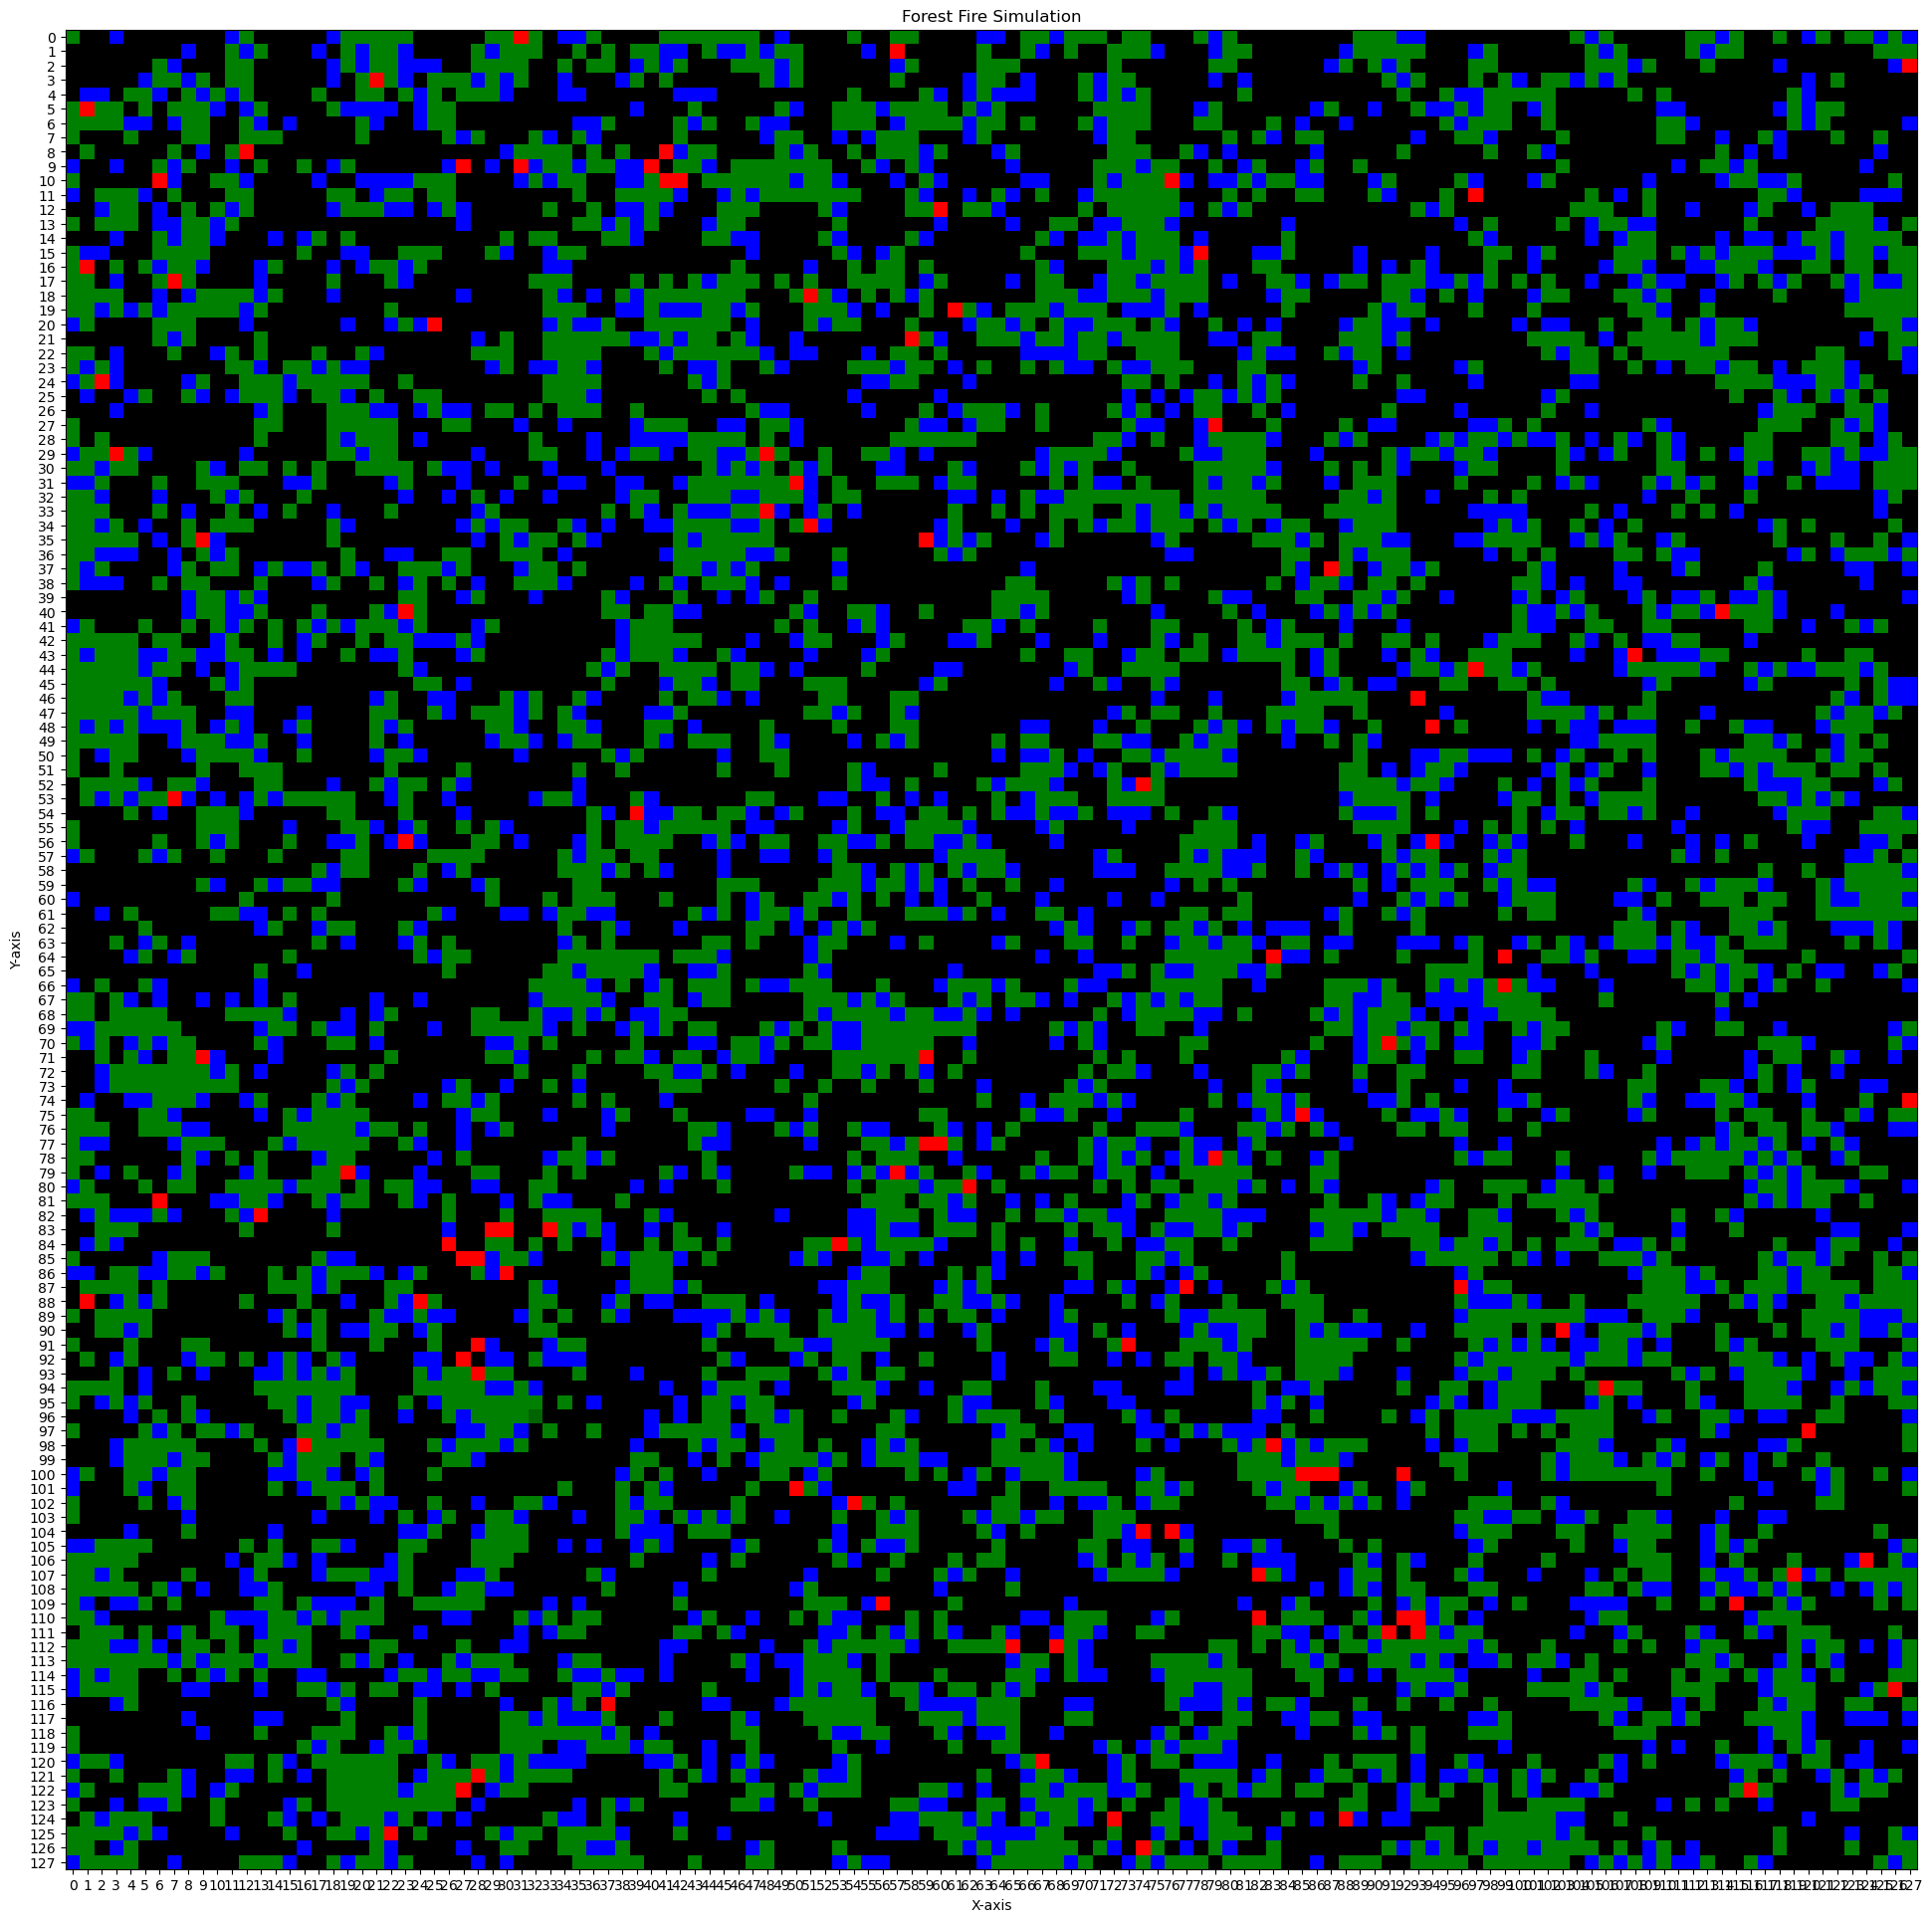

Iteration: 21


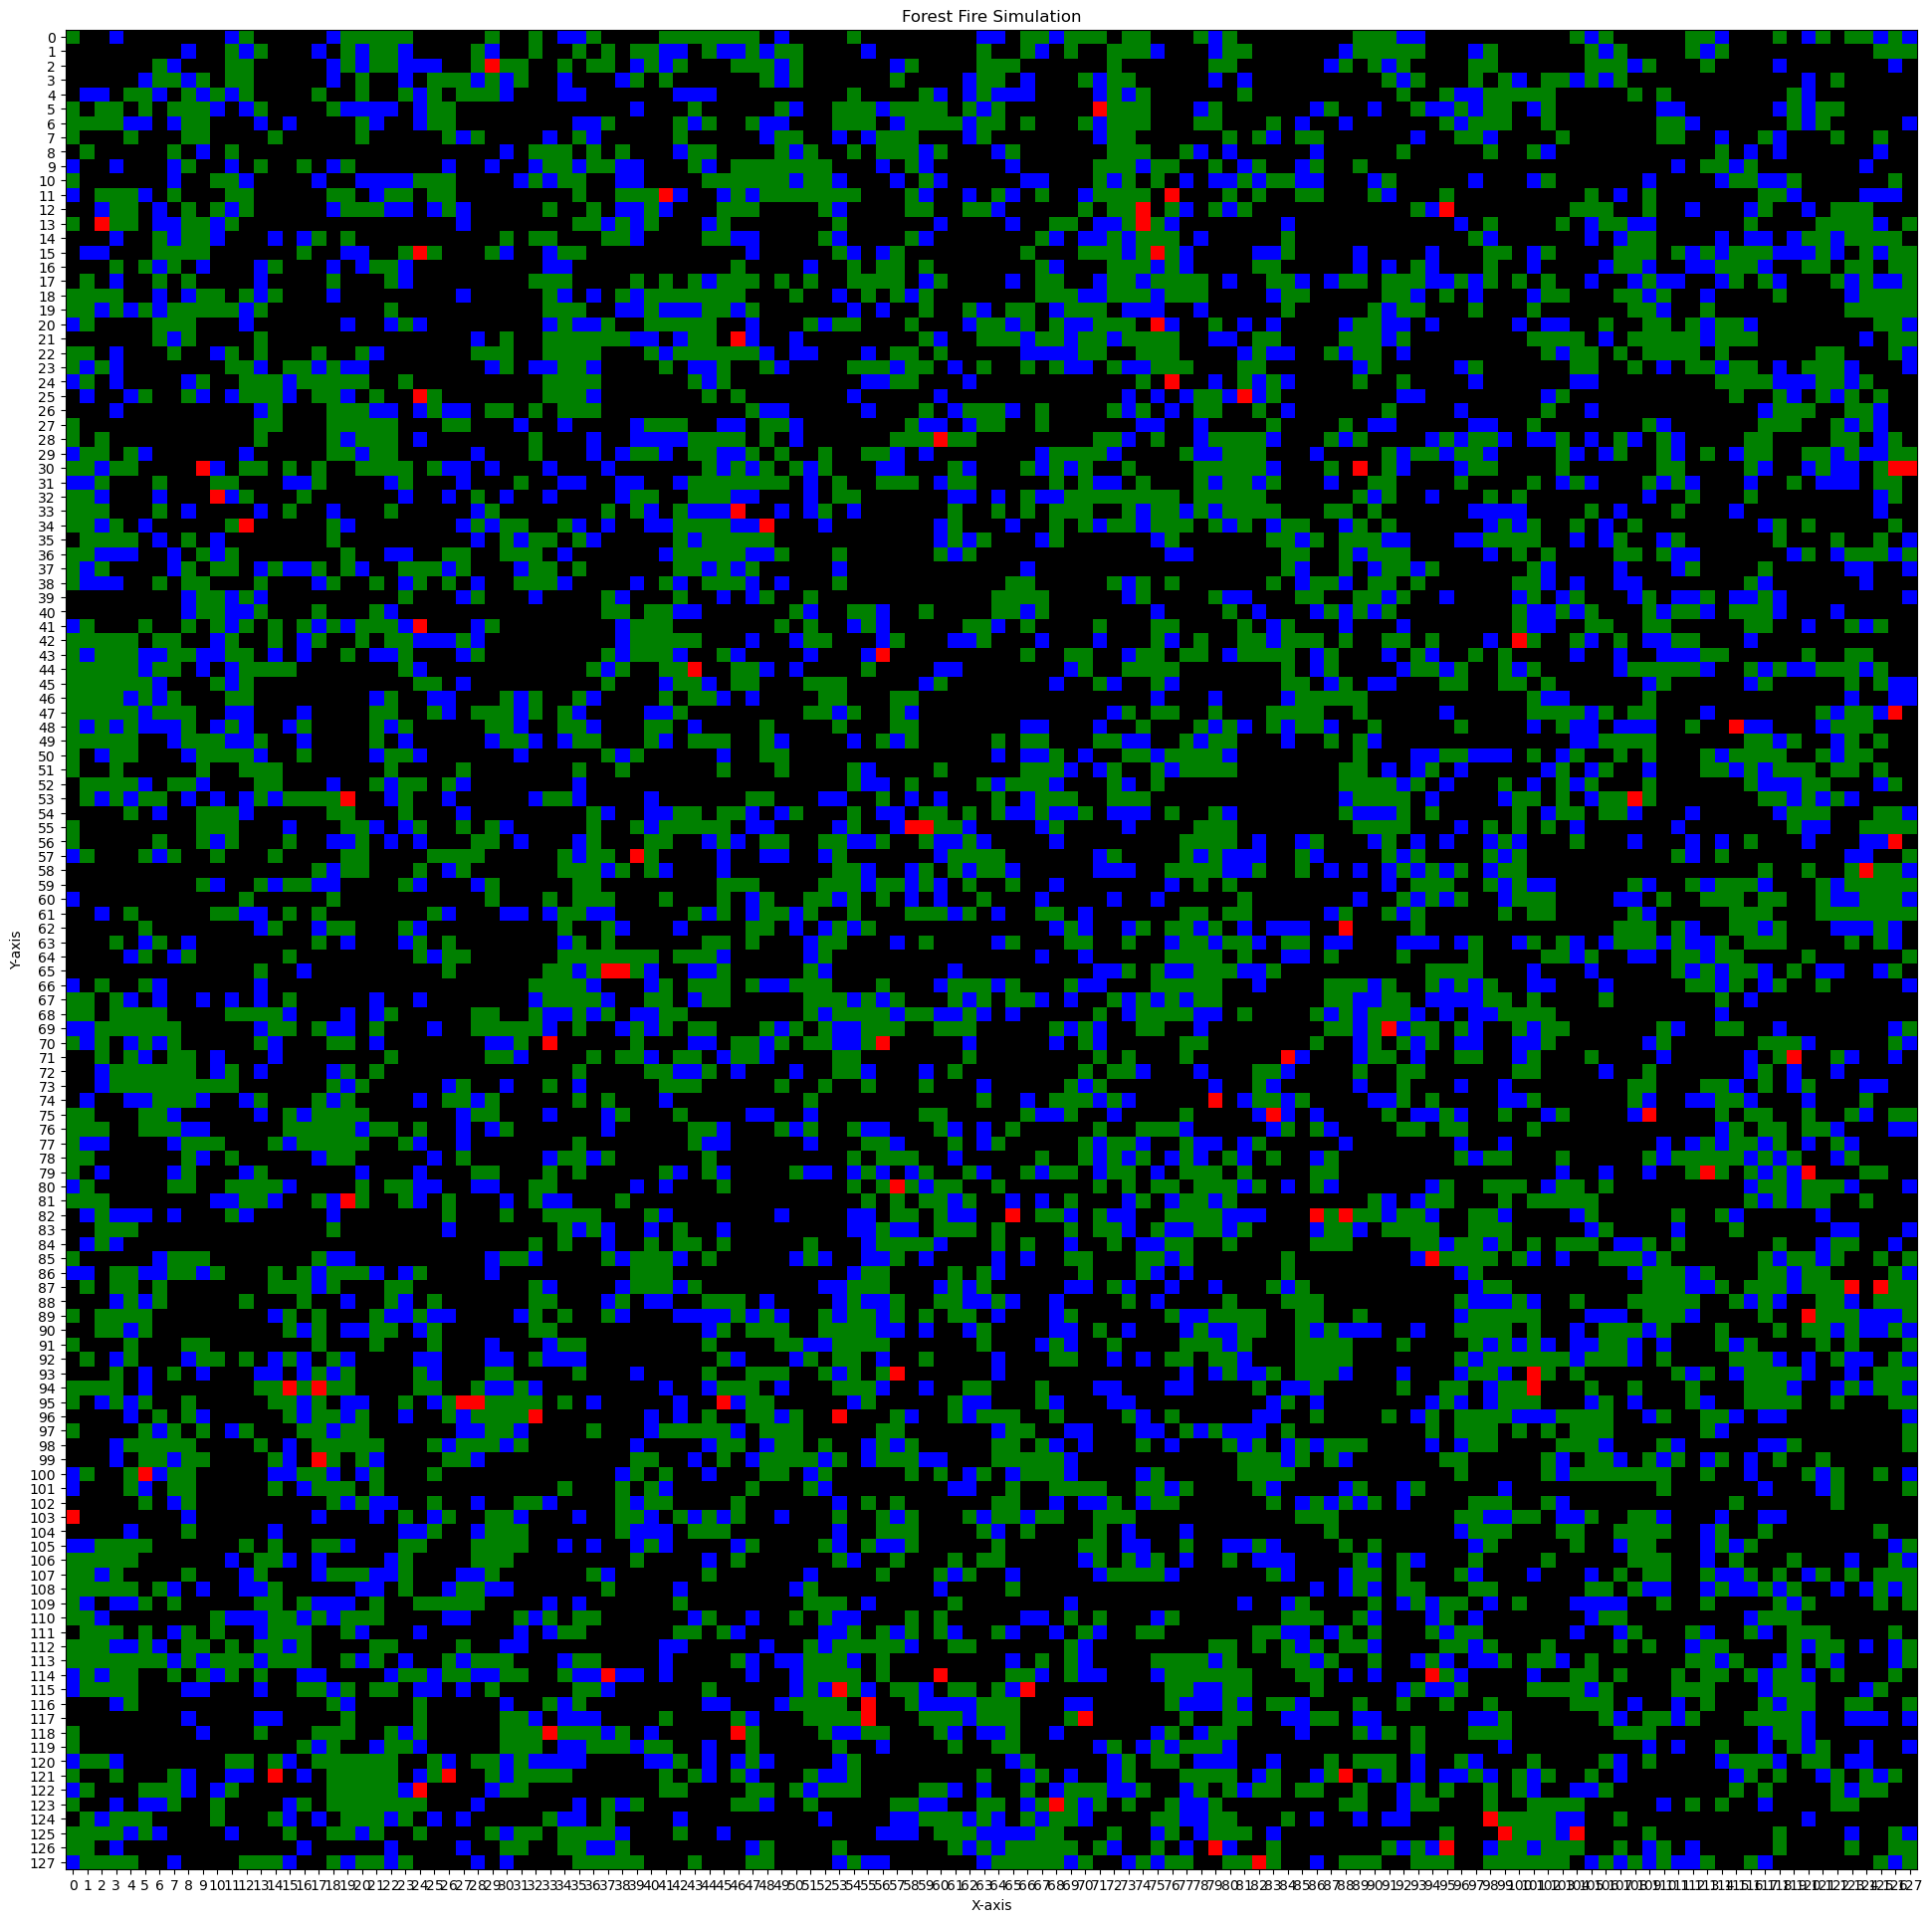

Iteration: 24


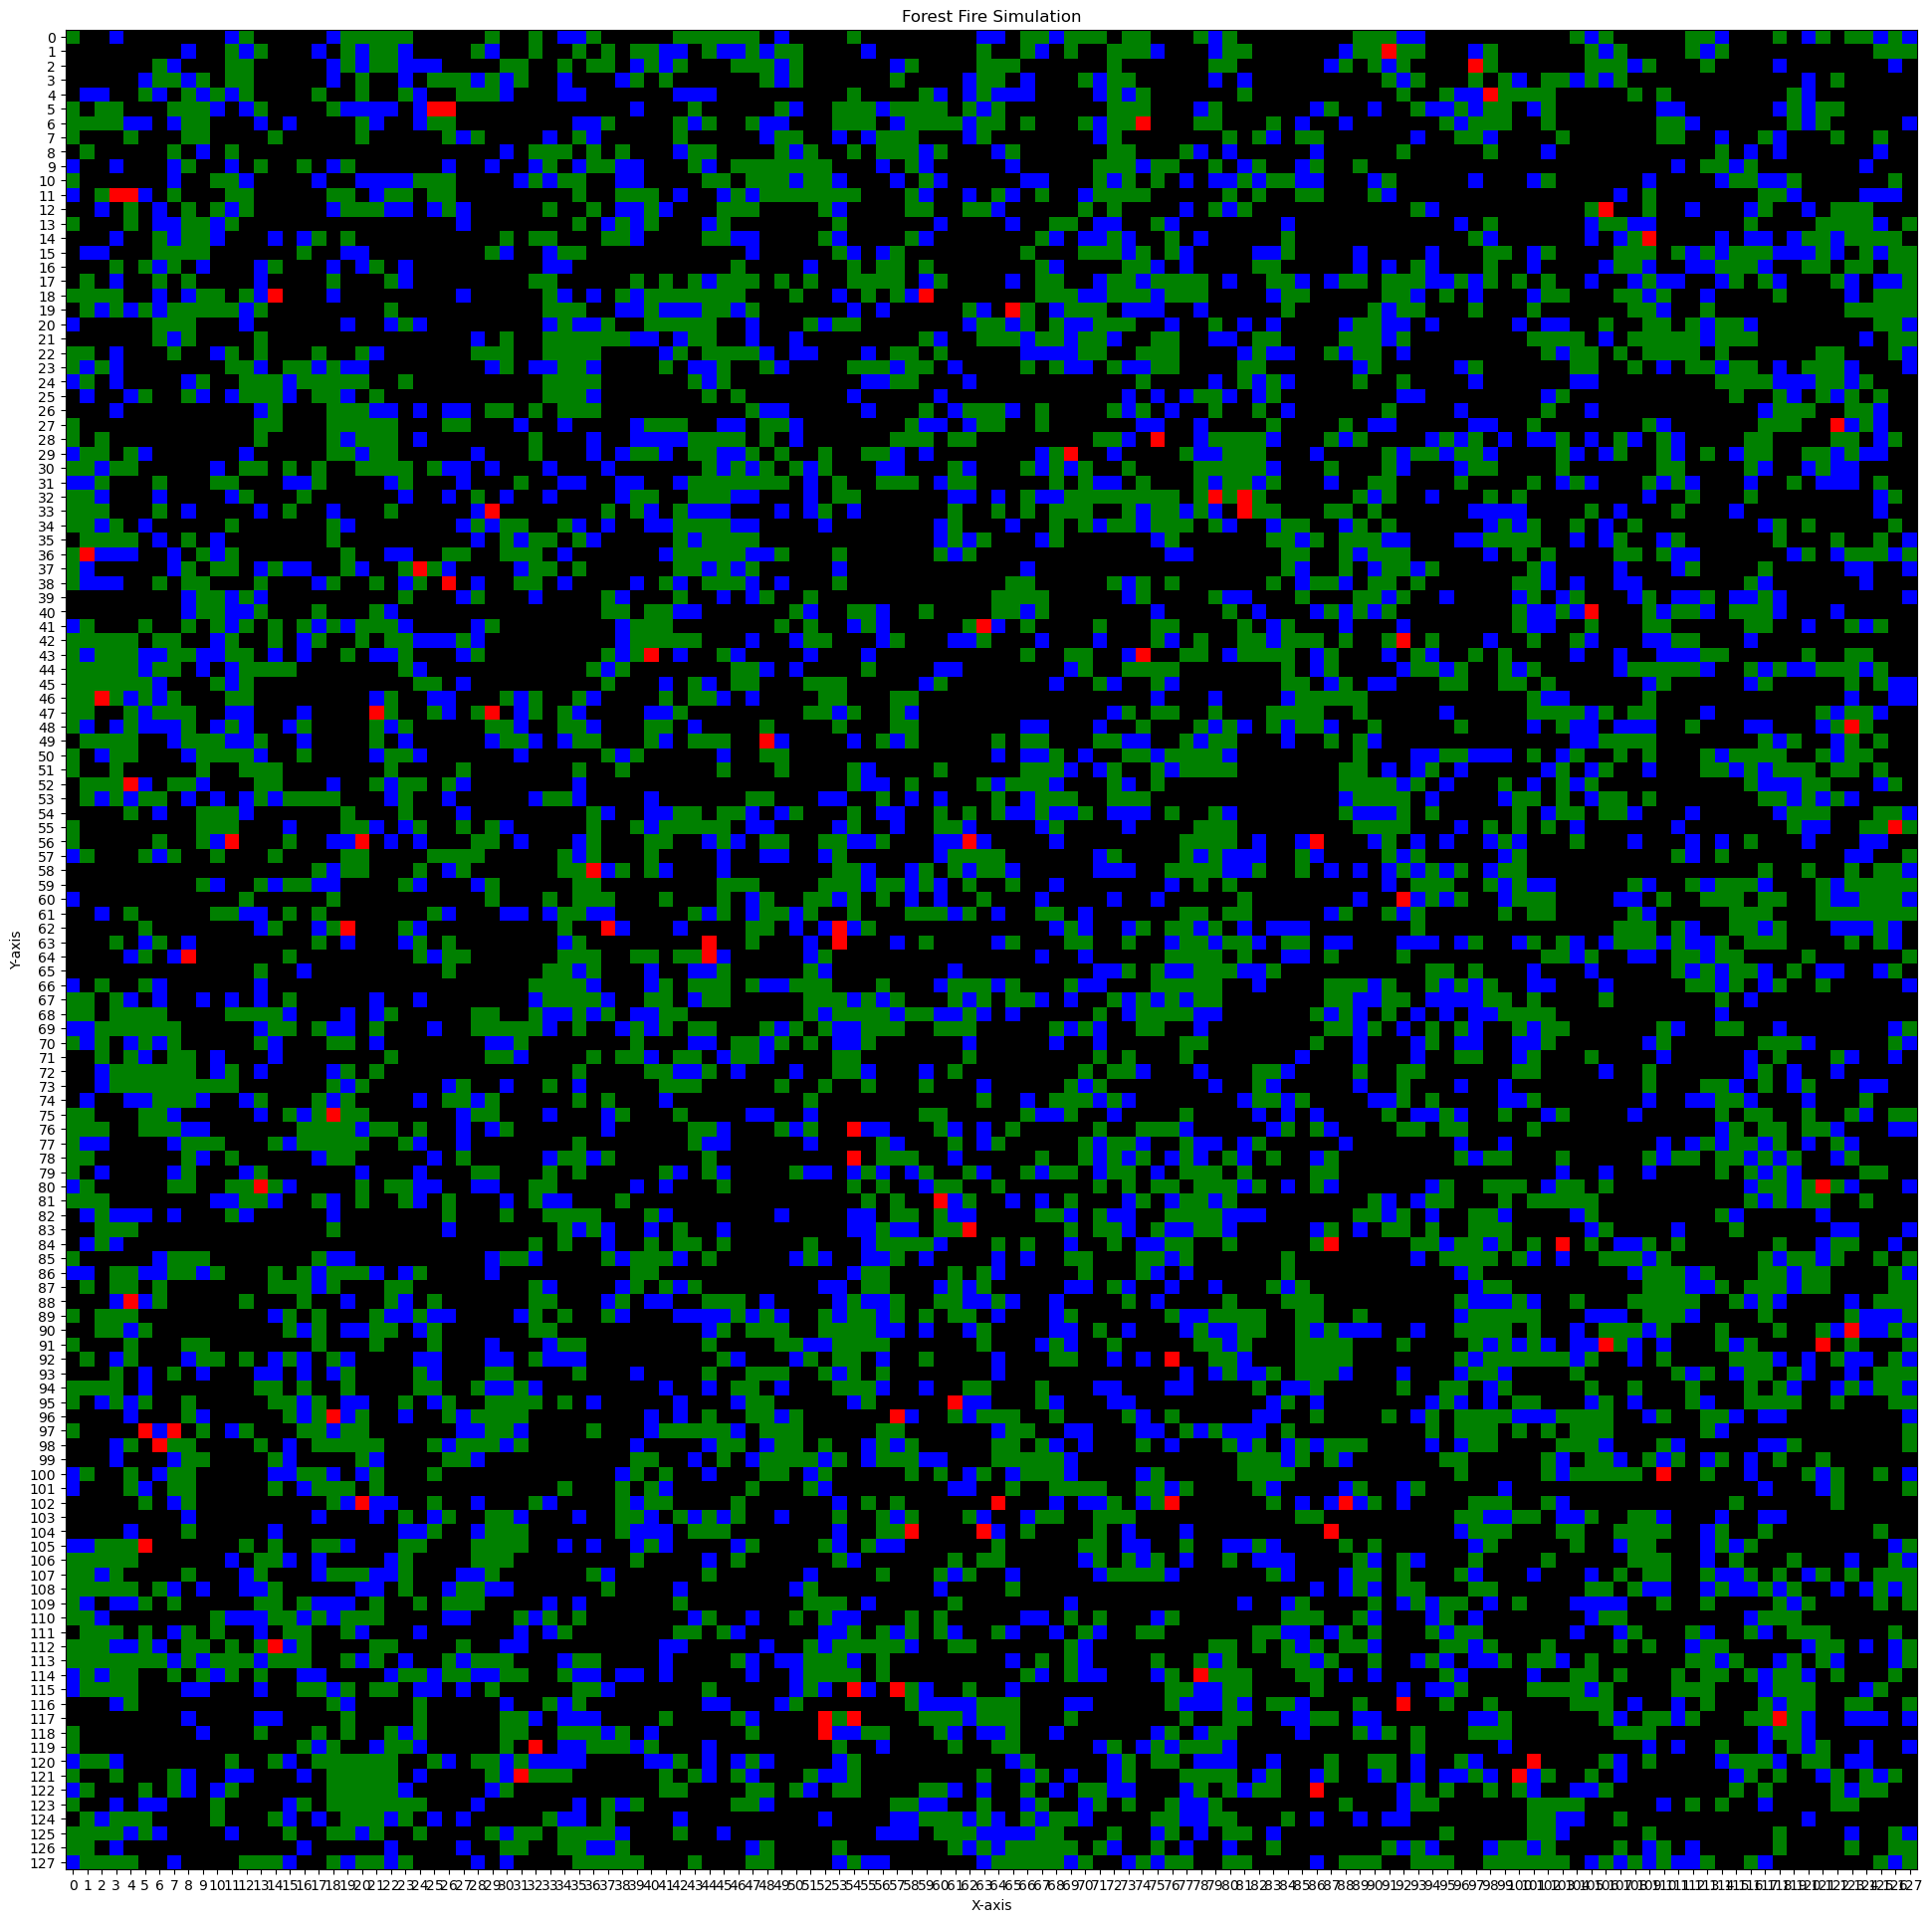

Iteration: 27


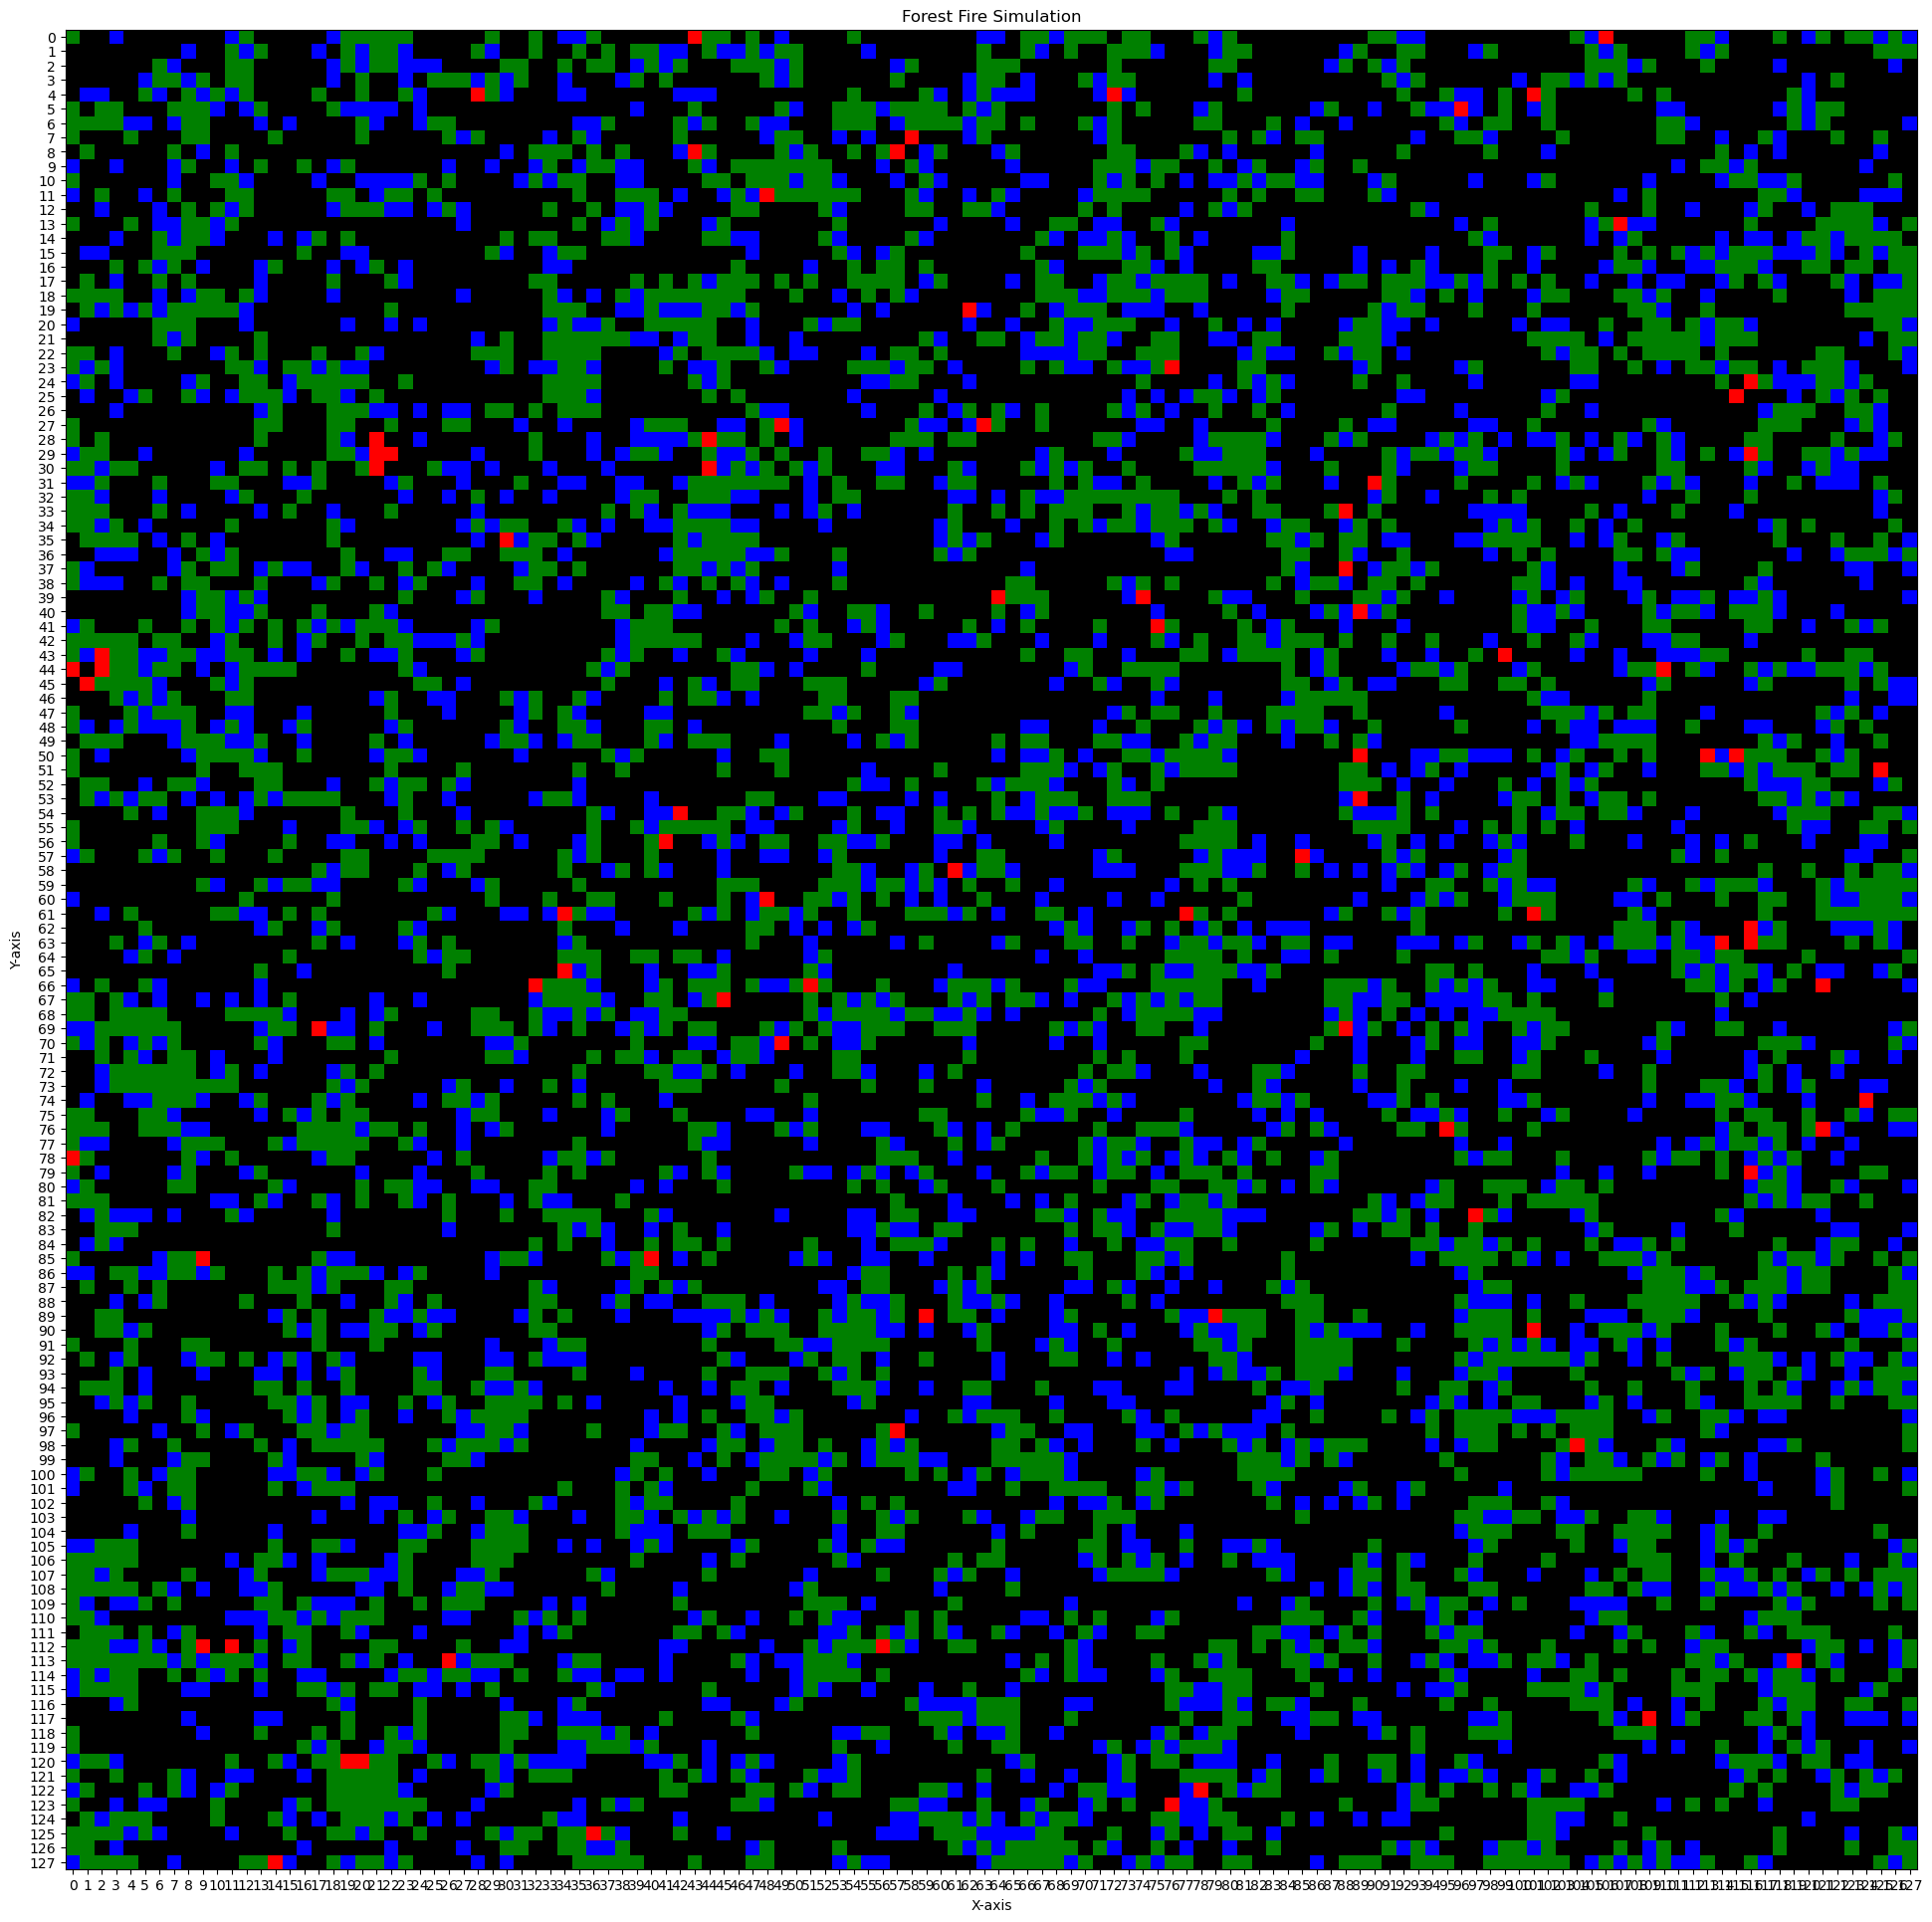

Iteration: 29


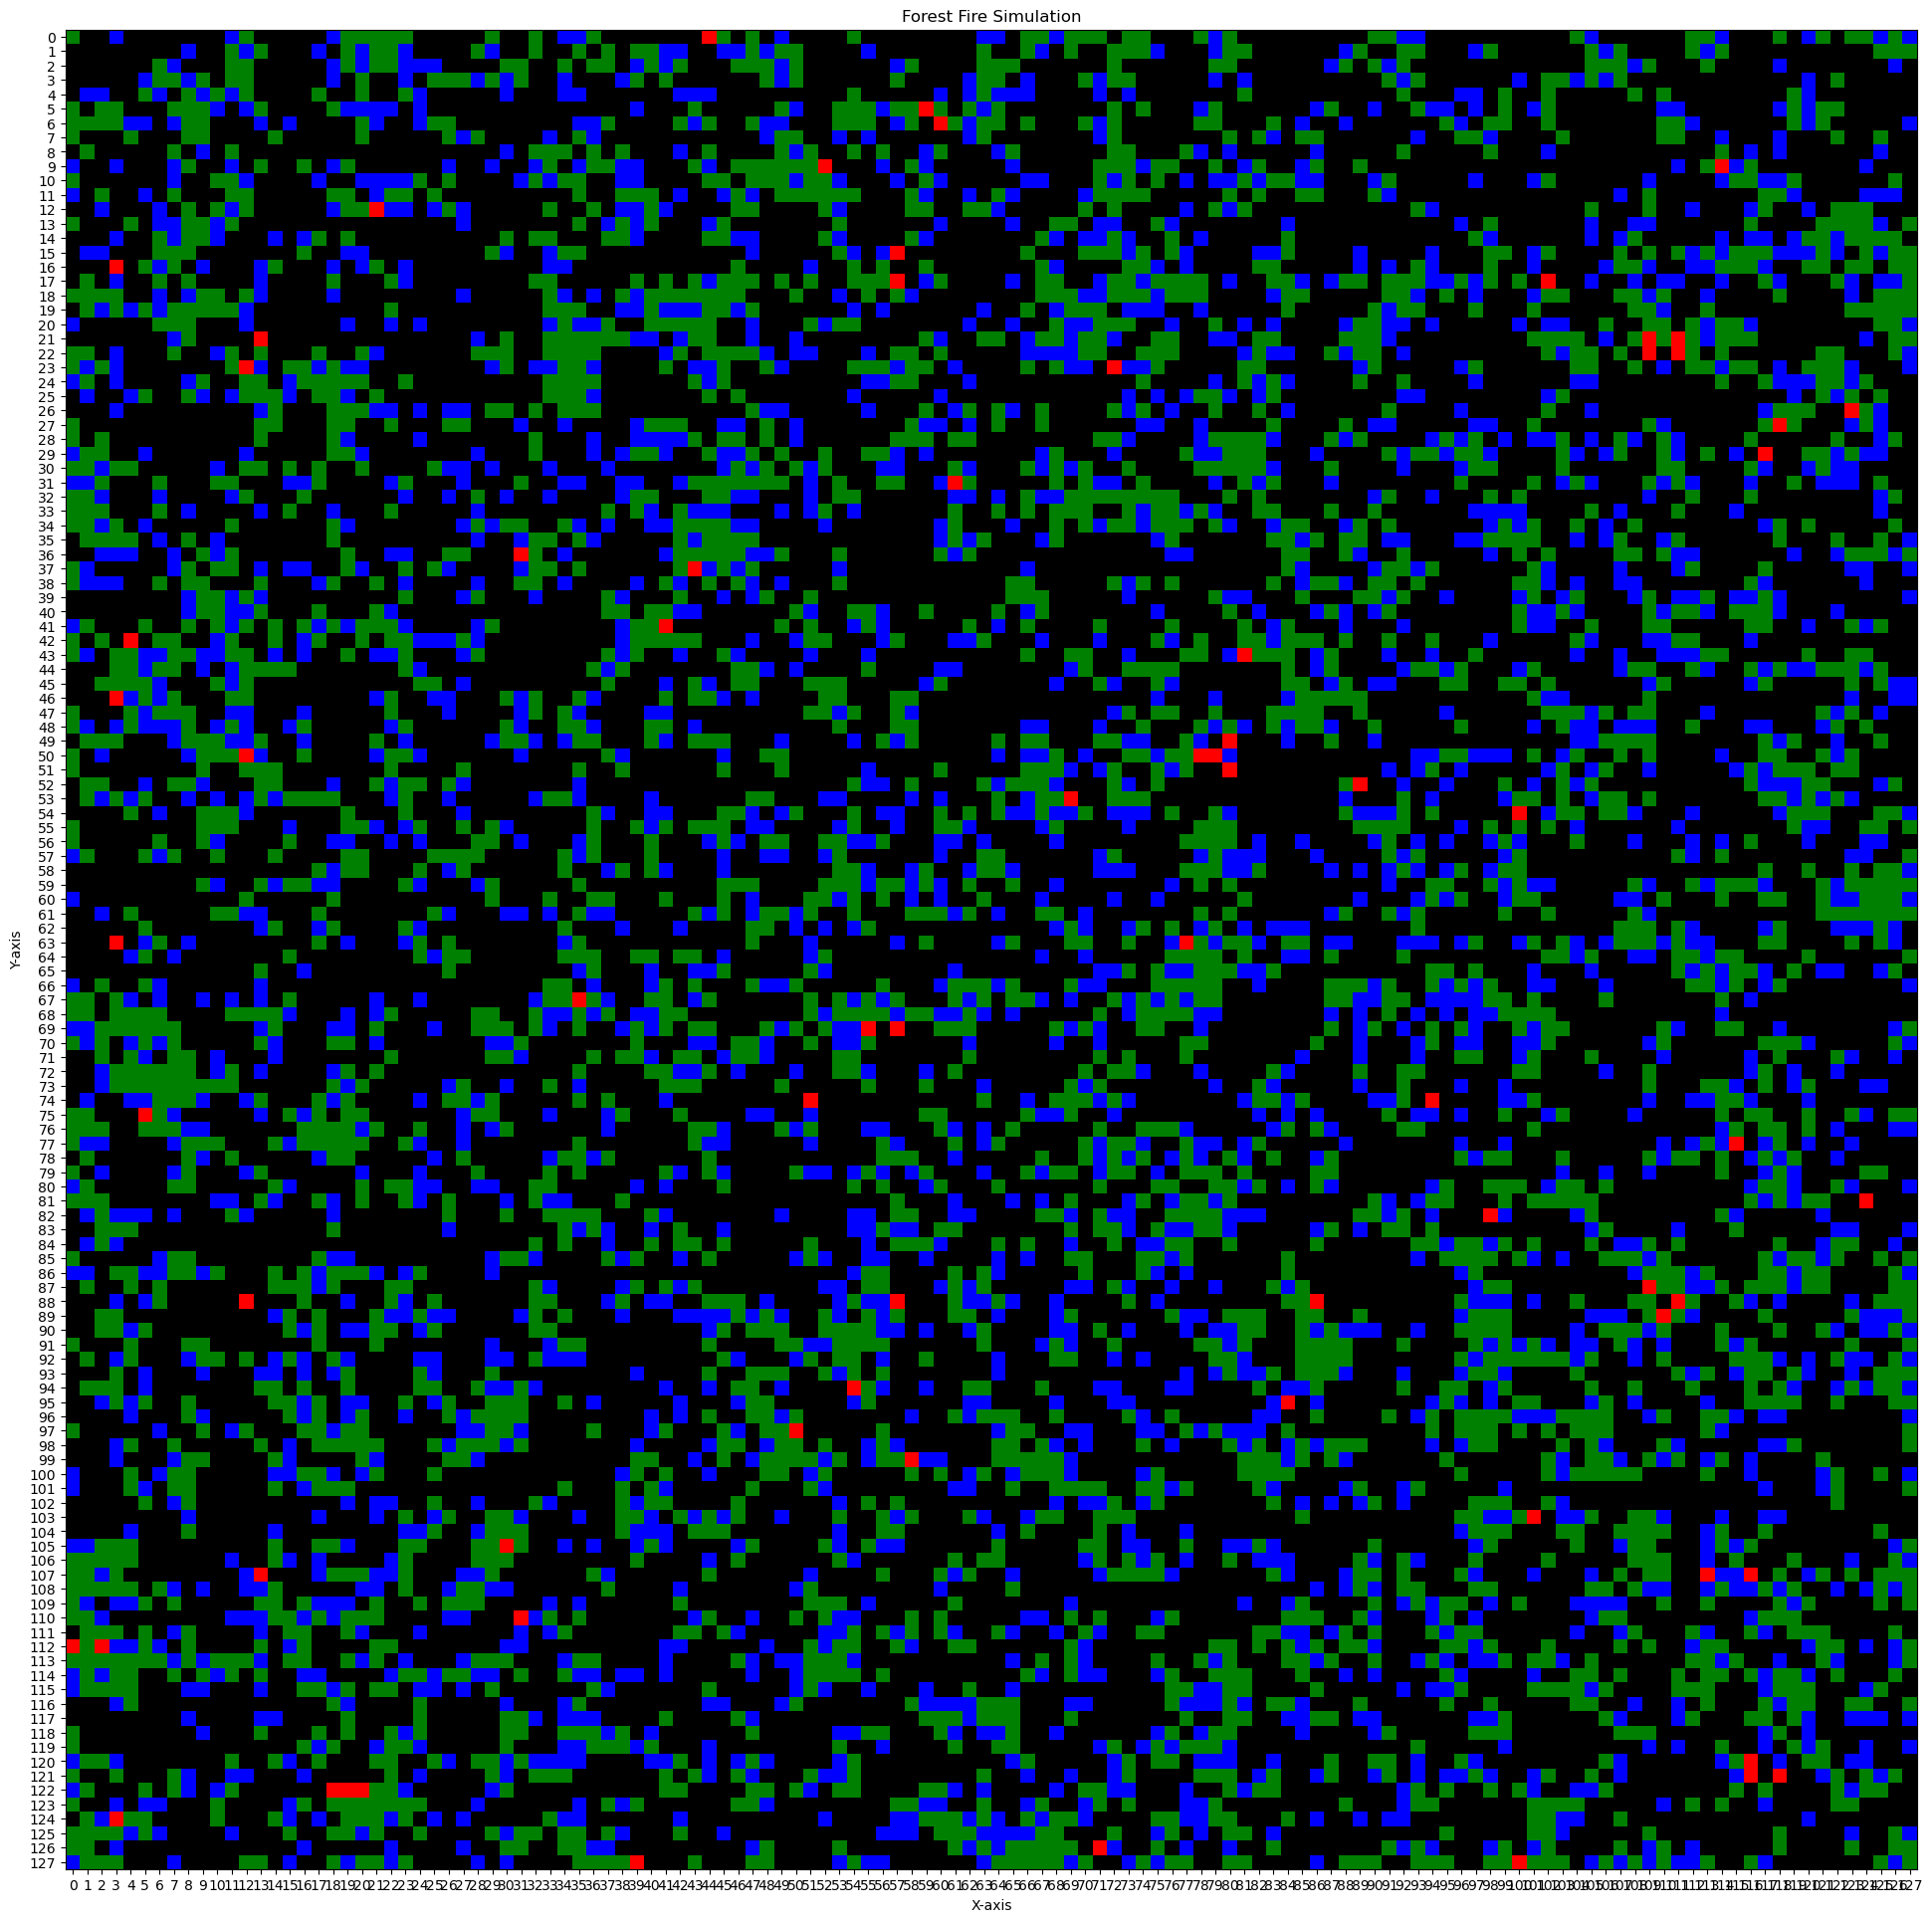

In [98]:

if __name__ == "__main__":
    m, n = 128, 128
    initial_grid = initialize_grid(m, n)
    terrain_elevation = np.random.uniform(low=0, high=100, size=(m, n))
    final_grid = simulate(initial_grid, p=0.8, pstart=0.01, num_iterations=30, plot_interval=3, w_speed=0.5, w_direction=WIND_ANGLE, terrain=terrain_elevation)
    